### Process NCANDA good data and test data

In [5]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn.plotting import plot_anat
from scipy.ndimage import zoom

dwi_files = np.loadtxt('ncanda_train_files.txt', dtype=str)

# Load images
def loadb0(img_file, as_type = 'nib', normalize = True, resize = True):
    # as_type should either be nib for nibabel format or np for numpy array
    if as_type not in ['nib', 'np']:
        raise TypeError('Incorrect option for as_type. Use either nib or np.')
    # Load image
    img = nib.load(img_file)
    img_fixed = img.get_fdata()
    # Normalize intensity to range of 0 to 1
    if normalize:
        img_fixed = (img_fixed - np.min(img_fixed, axis = (0,1,2))) / (np.max(img_fixed, axis = (0,1,2)) - np.min(img_fixed, axis = (0,1,2)))
    if resize:
        if img_fixed.shape[0] != 96:
            img_fixed = zoom(img_fixed, (0.75,0.75,1))
    if as_type == 'np':
        return img_fixed
    elif as_type == 'nib':
        # Reform as image data type
        img_fixed = nib.Nifti1Image(img_fixed, np.eye(4))
        return img_fixed

In [ ]:
for i in range(70):
    plt.close('all')
    dwi = loadb0(dwi_files[i], as_type = 'np')
    dwi[:,:,-8:] = 0
    dwi = nib.Nifti1Image(dwi, np.eye(4))
    fig, ax = plt.subplots(1,1,figsize = (12,4))
    plot_anat(dwi, axes = ax, vmin = -0.1, vmax = 0.3)
    plt.show()

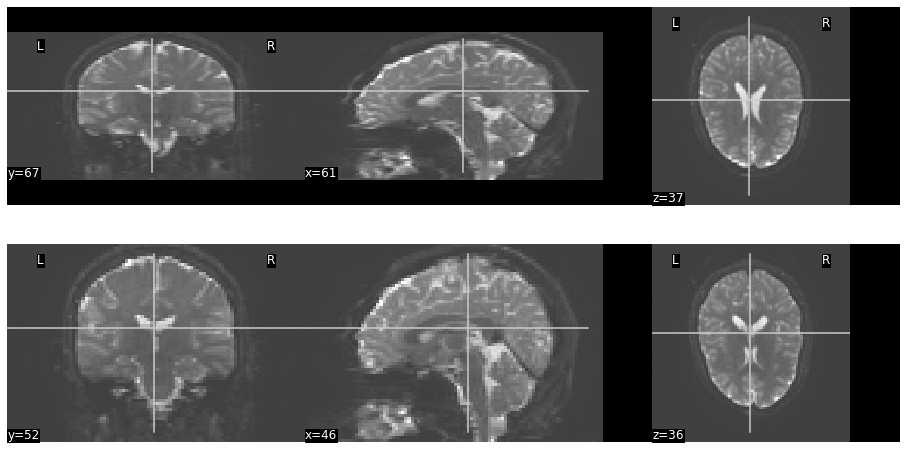

In [55]:
dwi1 = loadb0(dwi_files[0], resize = False)
dwi2 = loadb0(dwi_files[0], resize = True)
fig, ax = plt.subplots(2,1,figsize = (16,8))
plot_anat(dwi1, axes = ax[0], vmin = -0.1, vmax = 0.3)
plot_anat(dwi2, axes = ax[1], vmin = -0.1, vmax = 0.3)
plt.show()

Adding rotation
Adding translation
Adding noise


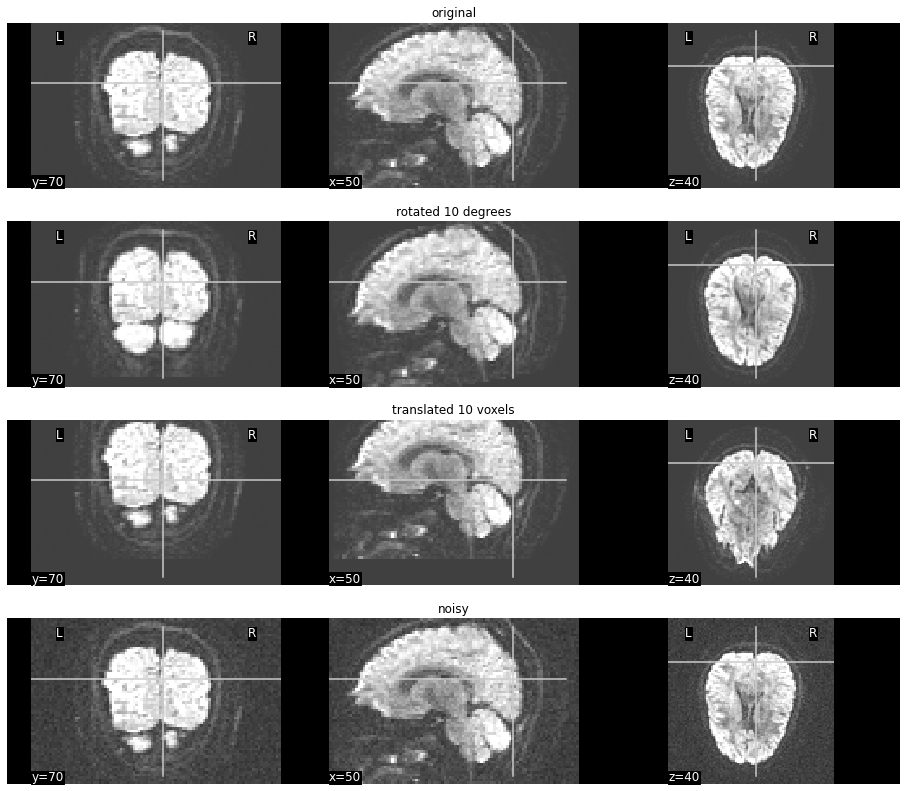

In [2]:
from scipy.ndimage import rotate, shift
from skimage.util import random_noise

def add_rotation(image3d, amount, axis):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
    
    axes = [0,1,2]
    axes.remove(axis)
    # Apply rotation
    img_rotated = rotate(img, amount, axes = tuple(axes), reshape = False)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img_rotated = nib.Nifti1Image(img_rotated, np.eye(4))
    
    return img_rotated

def add_translation(image3d, amount, axis):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
        
    shift_apply = np.zeros((3,))
    shift_apply[axis] = amount
    # Apply translation
    img_translated = shift(img, shift_apply)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img_translated = nib.Nifti1Image(img_translated, np.eye(4))
        
    return img_translated

def add_noise(image3d, amount = 0.0001):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
    
    noisy_img = random_noise(img, mode = 'gaussian', clip = True, var = amount)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        noisy_img = nib.Nifti1Image(noisy_img, np.eye(4))
    
    return noisy_img

idx = np.random.choice(dwi_files.shape[0], 1)[0]
dwi = loadb0(dwi_files[idx])
print('Adding rotation')
dwi_rotated = add_rotation(dwi, 10, 0)
print('Adding translation')
dwi_translated = add_translation(dwi, 10, 2)
print('Adding noise')
dwi_noisy = add_noise(dwi)

plt.close('all')
fig,ax = plt.subplots(4,1, figsize = (16,14))
plot_anat(dwi, axes = ax[0], vmin = -0.1, vmax = 0.3, cut_coords = (50,70,40))
ax[0].set_title('original')
plot_anat(dwi_rotated, axes = ax[1], vmin = -0.1, vmax = 0.3, cut_coords = (50,70,40))
ax[1].set_title('rotated 10 degrees')
plot_anat(dwi_translated, axes = ax[2], vmin = -0.1, vmax = 0.3, cut_coords = (50,70,40))
ax[2].set_title('translated 10 voxels')
plot_anat(dwi_noisy, axes = ax[3], vmin = -0.1, vmax = 0.3, cut_coords = (50,70,40))
ax[3].set_title('noisy')
plt.show()

In [ ]:
import os

file_list = []
num_files = dwi_files.shape[0] // 2
file_idx = np.random.randint(0, dwi_files.shape[0], size = num_files)
for ind,file_path in enumerate(dwi_files[file_idx]):
    #if ind < 130: continue
    #print('Augmenting ' + file_path)
    print('Processing %d of %d files' % ((ind + 1), dwi_files[file_idx].shape[0]))
    subj = file_path.split('/')[-4].split('_')[-1]
    filenum = file_path.split('/')[-1].split('.')[0].split('-')[-1]
    dwi = loadb0(file_path, as_type = 'np')
    # Original file
    prefix = 'ncanda/traindata/' + subj
    if not os.path.exists(prefix):
        os.makedirs(prefix)
    if '1.nii.gz' in file_path or '2.nii.gz' in file_path:
        prefix = prefix + '/b0vol' + filenum
    else:
        prefix = prefix + '/nonb0vol' + filenum
    savename = prefix + '_original.npy'
    np.save(savename, dwi)
    file_list.append(savename)
    # Rotate and translate
    i = 1
    for amount in [-10, 10]:
        for axis in [0,1,2]:
            dwi_preprocess = add_rotation(dwi, amount, axis)
            savename = prefix + '_rotate' + str(i) + '.npy'
            np.save(savename, dwi_preprocess)
            file_list.append(savename)
            if axis != 2:
                dwi_preprocess = add_translation(dwi, amount, axis)
                savename = prefix + '_translate' + str(i) + '.npy'
                np.save(savename, dwi_preprocess)
                file_list.append(savename)
            i += 1
#     # Noise
#     dwi_preprocess = add_noise(dwi)
#     savename = prefix + '_noisy.npy'
#     np.save(savename, dwi_preprocess)
#     file_list.append(savename)
print('Number of training samples: ' + str(len(file_list)))

np.savetxt('ncanda/X_files.txt', file_list, fmt = '%s')

Processing 1 of 57411 files
Processing 2 of 57411 files
Processing 3 of 57411 files
Processing 4 of 57411 files
Processing 5 of 57411 files
Processing 6 of 57411 files
Processing 7 of 57411 files
Processing 8 of 57411 files
Processing 9 of 57411 files
Processing 10 of 57411 files
Processing 11 of 57411 files
Processing 12 of 57411 files
Processing 13 of 57411 files
Processing 14 of 57411 files
Processing 15 of 57411 files
Processing 16 of 57411 files
Processing 17 of 57411 files
Processing 18 of 57411 files
Processing 19 of 57411 files
Processing 20 of 57411 files
Processing 21 of 57411 files
Processing 22 of 57411 files
Processing 23 of 57411 files
Processing 24 of 57411 files
Processing 25 of 57411 files
Processing 26 of 57411 files
Processing 27 of 57411 files


In [6]:
dwi_files = np.loadtxt('ncanda_test_files.txt', dtype=str)

def getb0(list_files, nonb0 = False):
    final_list = []
    fixed_files = []
    for file in list_files:
        fixed_name = '/'.join(['ncanda_fixed'] + file.split('/')[-5:])
        bval, imagenum = file.split('/')[-2:]
        if 'pepolar' in bval:
            if '1' in imagenum:
                if nonb0:
                    continue
                else:
                    final_list.append(file)
                    fixed_files.append(fixed_name)
        elif '01' in imagenum or '02' in imagenum:
            if nonb0:
                continue
            else:
                final_list.append(file)
                fixed_files.append(fixed_name)
        if nonb0:
            final_list.append(file)
            fixed_files.append(fixed_name)
    
    return final_list, fixed_files

dwi_files, target_files = getb0(dwi_files)
np.savetxt('ncanda/X_test_files.txt', dwi_files, fmt = '%s')
np.savetxt('ncanda/fixed_file_locations.txt', target_files, fmt = '%s')
# dwi_files = getb0(dwi_files, nonb0 = True)
# np.savetxt('ncanda/X_nonb0_test.txt', dwi_files, fmt = '%s')

(96, 96, 64)


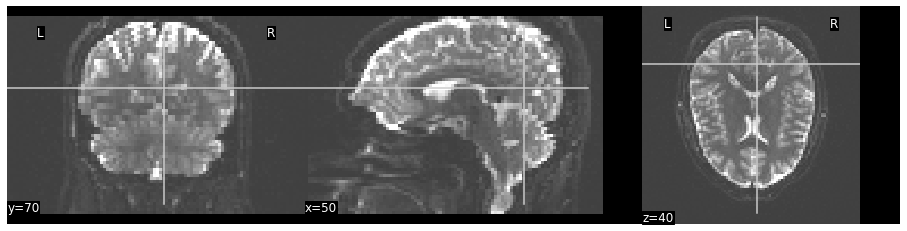

(96, 96, 64)


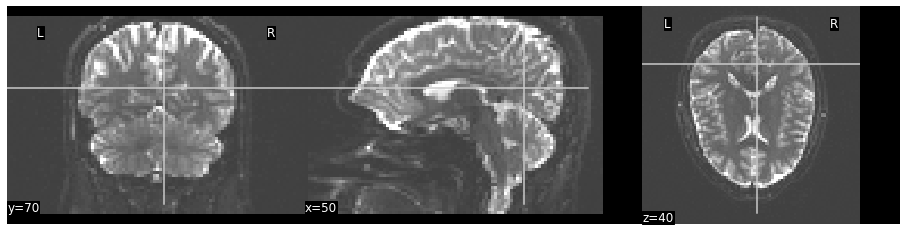

(96, 96, 64)


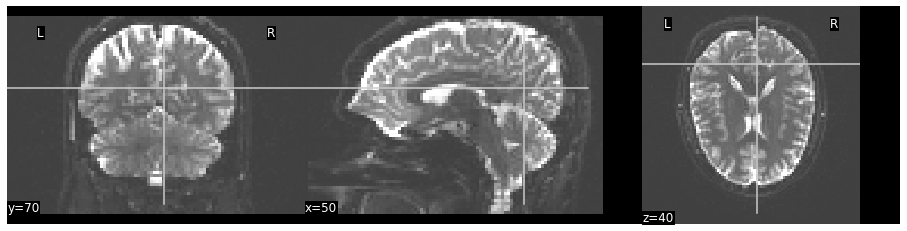

(96, 96, 64)


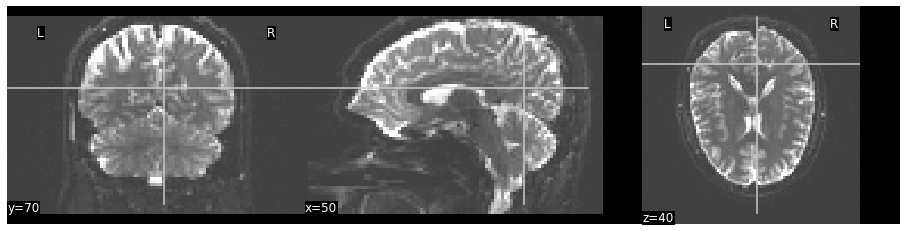

(96, 96, 64)


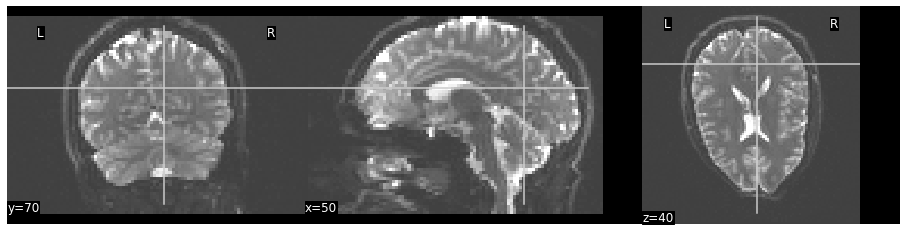

(96, 96, 64)


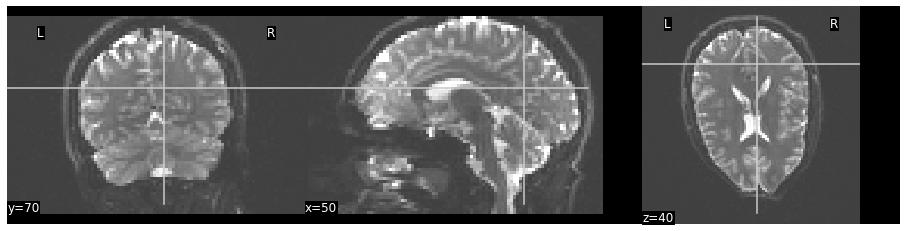

(96, 96, 64)


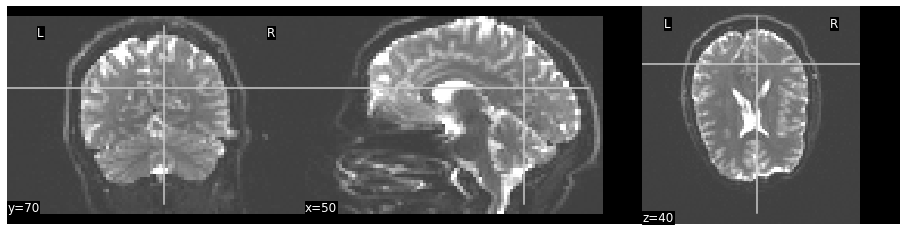

(96, 96, 64)


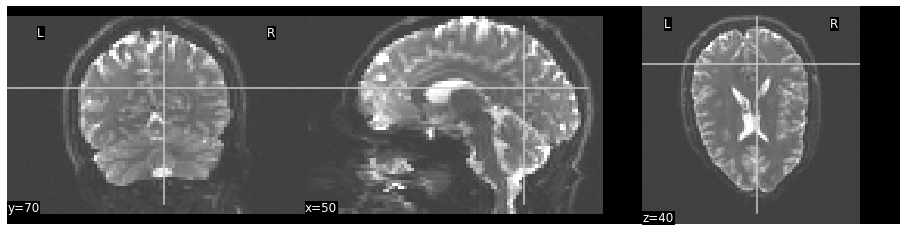

(96, 96, 64)


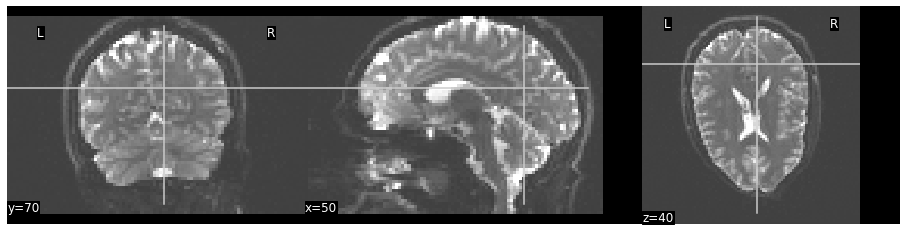

(96, 96, 64)


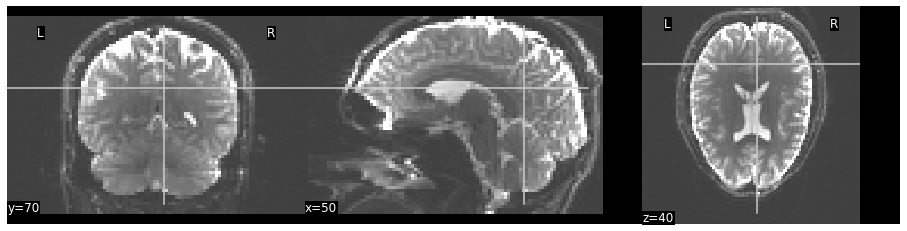

(96, 96, 64)


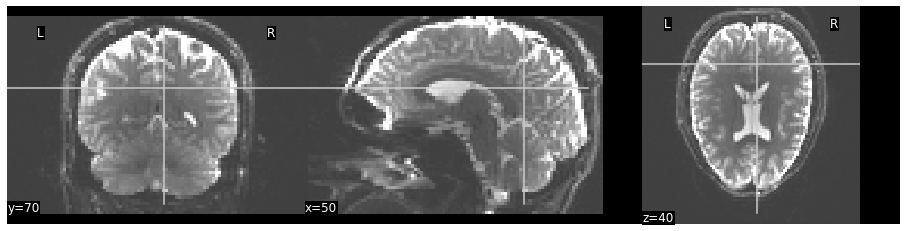

(96, 96, 64)


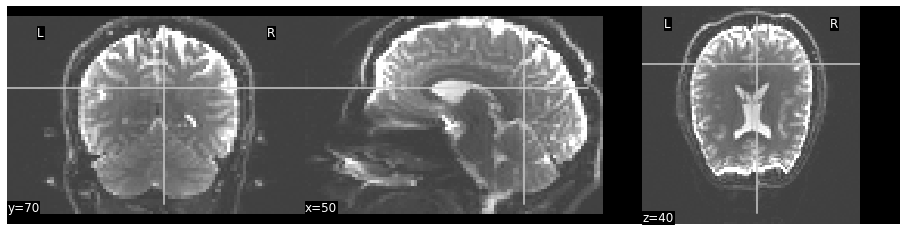

(96, 96, 64)


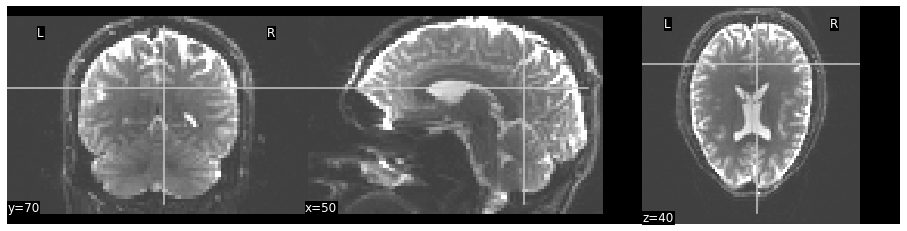

(96, 96, 64)


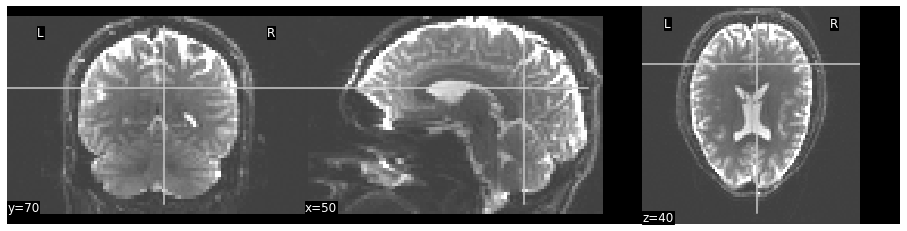

(96, 96, 64)


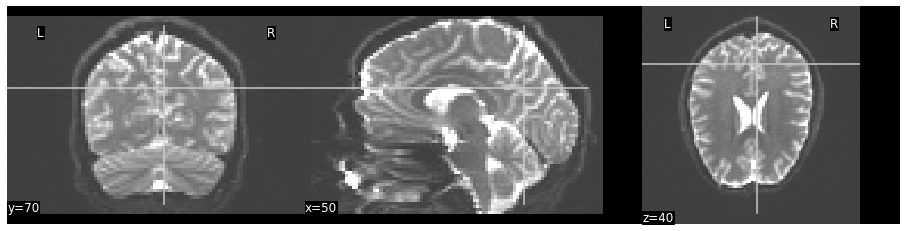

(96, 96, 64)


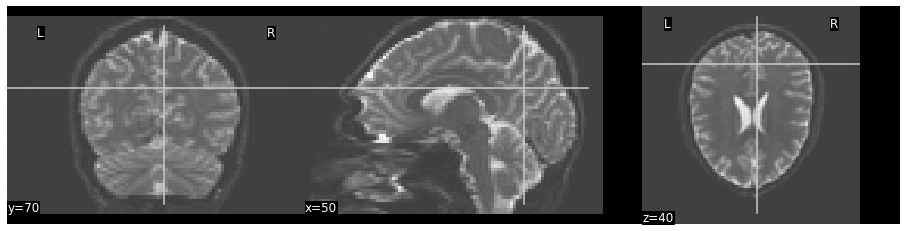

(96, 96, 64)


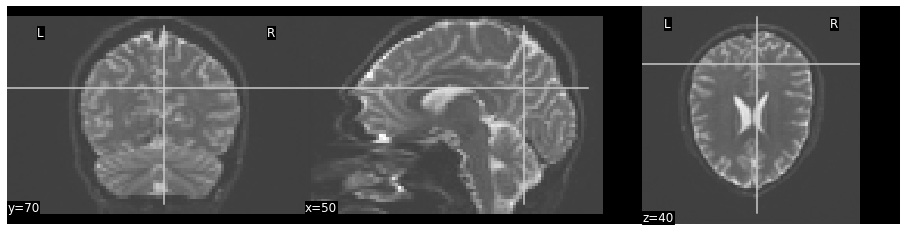

(96, 96, 64)


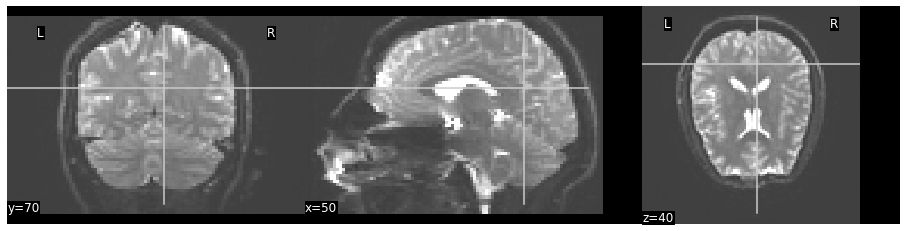

(96, 96, 64)


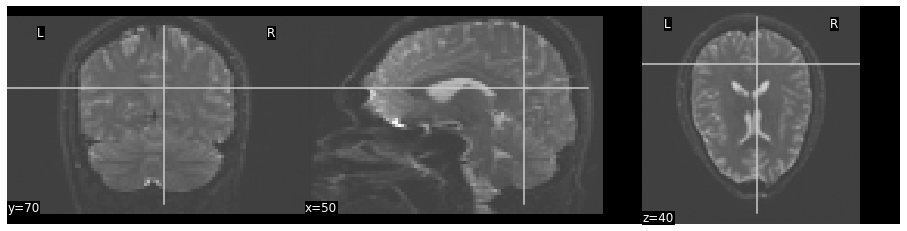

(96, 96, 64)


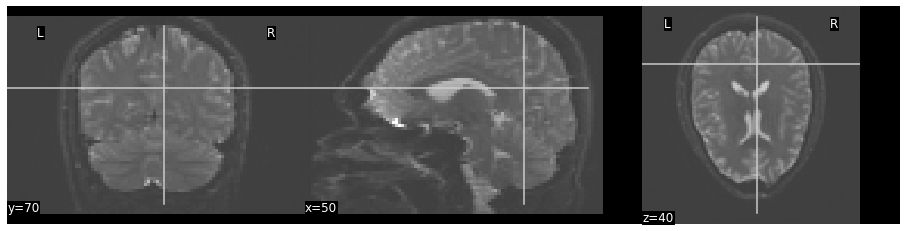

(96, 96, 64)


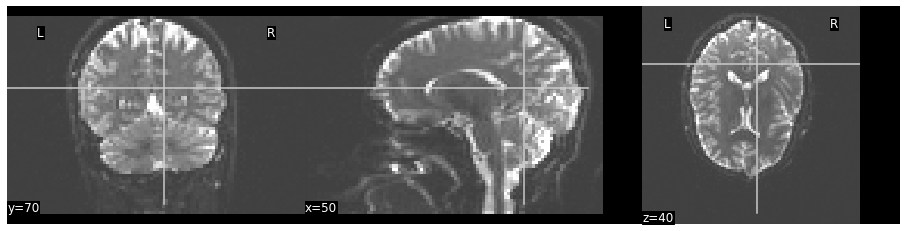

(96, 96, 64)


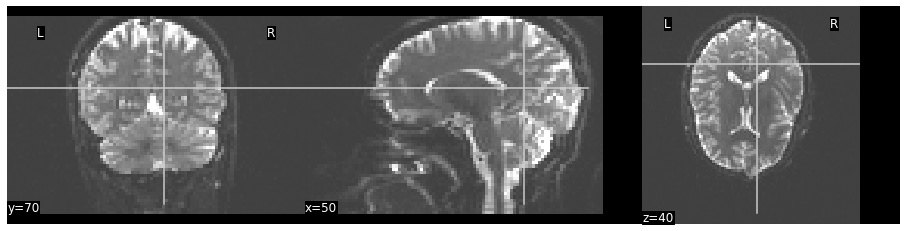

(96, 96, 64)


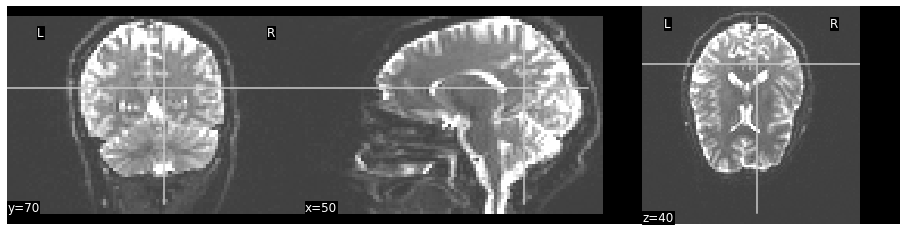

(96, 96, 64)


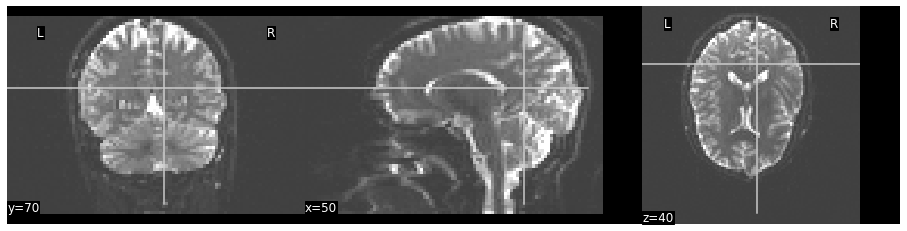

(96, 96, 64)


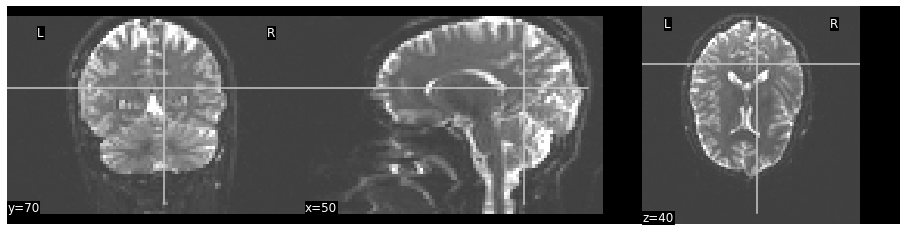

(96, 96, 64)


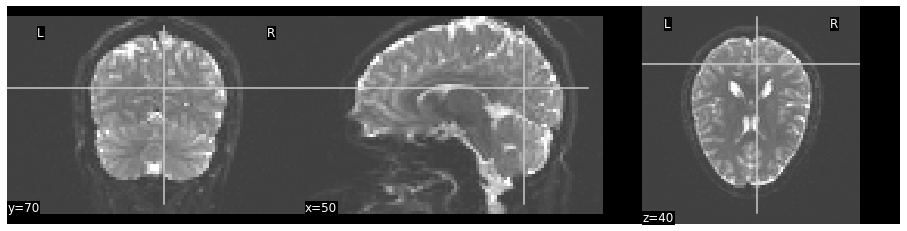

(96, 96, 64)


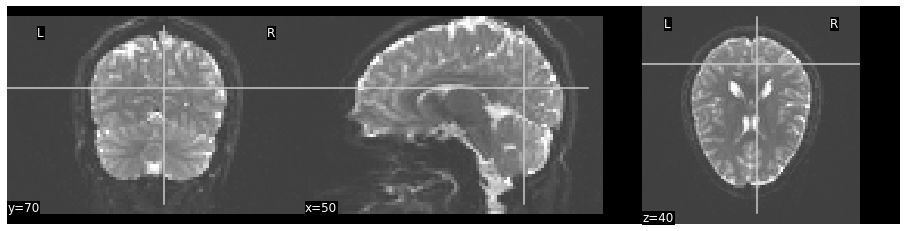

(96, 96, 64)


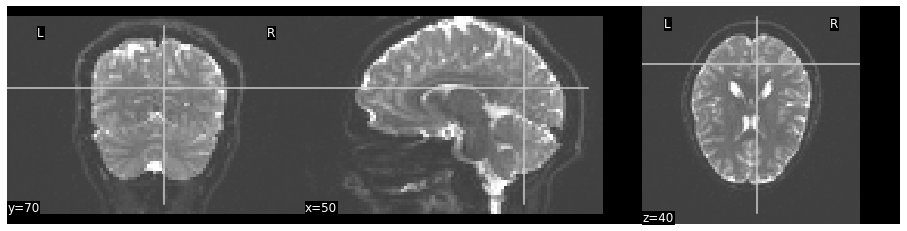

(96, 96, 64)


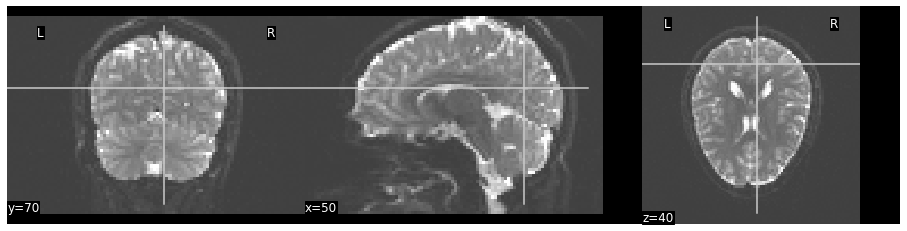

(96, 96, 64)


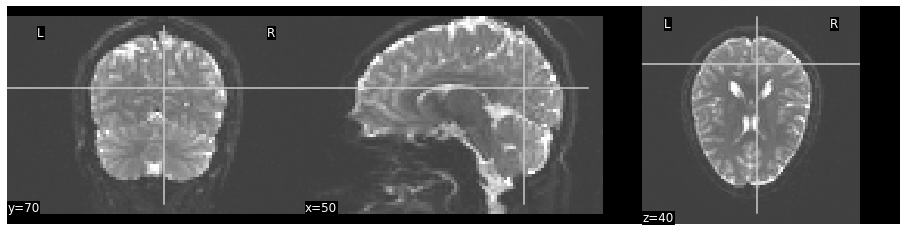

(96, 96, 64)


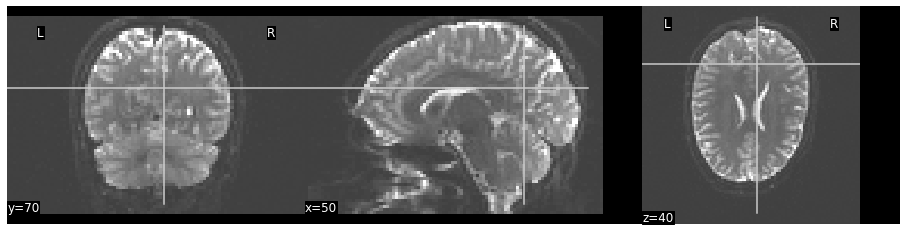

(96, 96, 64)


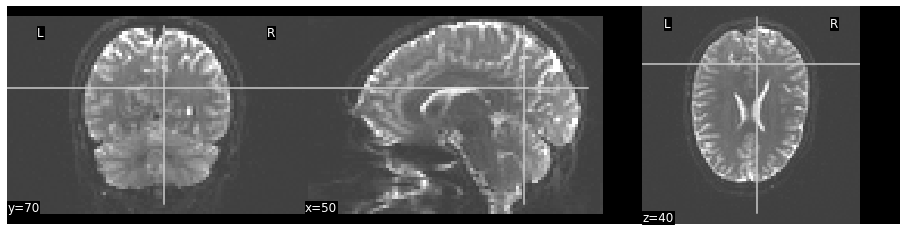

(96, 96, 64)


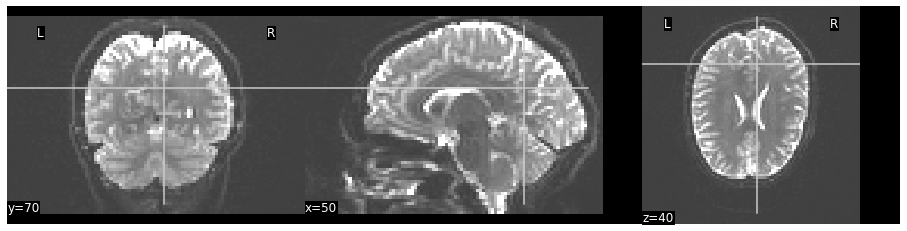

(96, 96, 64)


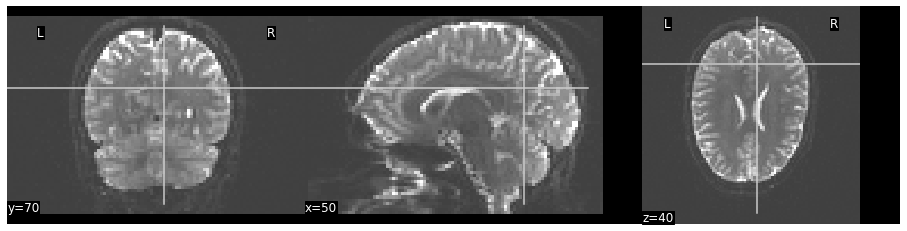

(96, 96, 64)


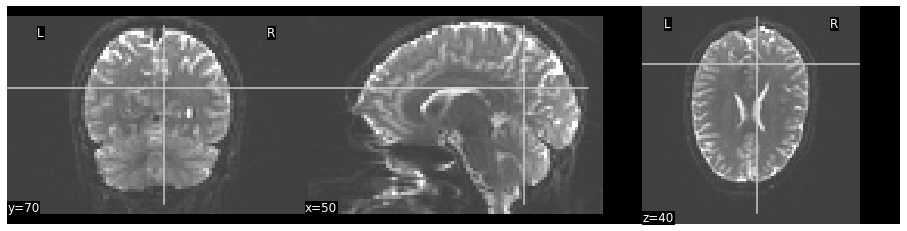

In [7]:
import os
from collections import defaultdict

sub_file_count = defaultdict(int)
file_list = []

for file in dwi_files:
    dwi = loadb0(file)
    print(dwi.shape)
    fig, ax = plt.subplots(1,1,figsize = (16,4))
    plot_anat(dwi, axes = ax, vmin = -0.1, vmax = 0.3, cut_coords = (50,70,40))
    plt.show()
    subj = file.split('/')[-4].split('_')[-1]
    suffix = file.split('/')[-1].split('.')[0]
    prefix = 'ncanda/testdata/' + subj
    if not os.path.exists(prefix):
        os.makedirs(prefix)
    #prefix += '/nonb0vol'
    prefix += '/b0vol'
    savename = prefix + '_image' + str(sub_file_count[subj]) + '.npy'
    file_list.append(savename)
    np.save(savename, dwi.get_fdata())
    sub_file_count[subj] += 1
    

#np.savetxt('ncanda/X_nonb0_test.txt', file_list, fmt = '%s')
np.savetxt('ncanda/X_test_files.txt', file_list, fmt = '%s')
    

## Train model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import numpy as np
import time, datetime
from Dataset import Dataset
from Models import *
from utils import *
from loss import *
from config import *
import pickle, os


# ===============================================================
# SPECIFY THESE
# ===============================================================
batch_size = 128
max_epochs = 70
cpu_batch_load_workers = 8
log_every_num_batches = 40
latent_dim = 512
model_save_path = 'models/ncanda_nonb0/'
input_shape = (1,96,96,64)
num_filters = 16
embedding_dim = 32
num_embeddings = 512
train_corrupt_prob = 1.0
valid_corrupt_prob = 1.0
num_corrupt = 8

# ===============================================================
# end
# ===============================================================


# Datasets
dwi_files1 = np.loadtxt('ncanda/X_files.txt', dtype=str)
dwi_files2 = np.loadtxt('X_resized_files.txt', dtype=str)
dwi_files_npy = np.concatenate((dwi_files1, dwi_files2))
print('Total number of samples: %d' % dwi_files_npy.shape[0])
np.random.seed(420)
np.random.shuffle(dwi_files_npy)
num_train = int(0.8 * dwi_files_npy.shape[0])
num_val = dwi_files_npy.shape[0] - num_train

"""
Reconstruction loss for a VAE except the cropped out portion the model must regenerate
from scratch is weighted more heavily
"""
def recon_masked_loss(x_orig, x_recon):
    device = 'cuda:0'
    mask = torch.full(input_shape, False, dtype=bool)
    mask[:,:,:,-num_corrupt:] = True
    mask = mask.to(device)
    weight = 10

    multiplier = torch.ones_like(x_orig)
    multiplier.masked_fill_(mask, weight)
    multiplier = multiplier.to(device)
    loss = nn.L1Loss(reduction = 'none')(x_recon, x_orig)
    loss.mul_(multiplier)

    return loss.sum()

loss_function = recon_masked_loss

Total number of samples: 420487


In [2]:
# Parameters
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': cpu_batch_load_workers}

# Generators
training_set = Dataset(dwi_files_npy[:num_train], corrupt_prob = train_corrupt_prob, num_corrupt = num_corrupt)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(dwi_files_npy[num_train:], corrupt_prob = valid_corrupt_prob, num_corrupt = num_corrupt)
validation_generator = data.DataLoader(validation_set, **params)

# model = VQVAE3D(input_shape[0], num_filters, embedding_dim = embedding_dim, num_embeddings = num_embeddings, skip_connections = True)
model = torch.load('models/ncanda_nonb0/Epoch_22_Train_loss_3228.0492_Test_loss_3455.3110.pth')

print(model)

# Optimization function
optimizer = optim.Adam(model.parameters(), lr=1e-3)

VQVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): VectorQuantizerEMA(
    (_embedding): Embedding(512, 32)
  )
  (decoder): VQDecoder_skip(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): ConvTranspose3d(128, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): ConvTrans

In [ ]:
# history = {'train': [], 'test': []}
with open('models/ncanda_nonb0/history.p', 'rb') as f:
    history = pickle.load(f)

# Loop over epochs
# for epoch in range(max_epochs):
for epoch in range(22, 50, 1):
    t0 = time.time()
    # Training
    train_loss = train(model, optimizer, loss_function, training_generator, epoch, log_every_num_batches = log_every_num_batches)

    # Validation
    test_loss = test(model, loss_function, validation_generator)
    
    savepath = os.path.join(model_save_path, 'Epoch_{}_Train_loss_{:.4f}_Test_loss_{:.4f}.pth'.format(epoch+1, train_loss, test_loss))
    # Save model
    torch.save(model, savepath)
    
    history['train'].append(train_loss)
    history['test'].append(test_loss)
    
    t_epoch = time.time() - t0
    print('====> Total time elapsed for this epoch: {:s}'.format(str(datetime.timedelta(seconds=int(t_epoch)))))

    with open(os.path.join(model_save_path, 'history.p'), 'wb') as f:
        pickle.dump(history, f)

====> Begin epoch 1

Train Epoch: 1 [1/2629 (0%)]	Loss: 59824.621094	ET - 16:21:23
Train Epoch: 1 [40/2629 (2%)]	Loss: 14486.253906	ET - 1:19:02
Train Epoch: 1 [80/2629 (3%)]	Loss: 11378.412109	ET - 1:23:49
Train Epoch: 1 [120/2629 (5%)]	Loss: 10771.288086	ET - 1:11:54


### Test model

In [ ]:
import torch
from torch.utils import data

from Dataset import Dataset
from Models import *
from utils import *
from loss import *
from config import *

import numpy as np
import matplotlib.pyplot as plt
import pickle
import nibabel as nib
from nilearn.plotting import plot_anat

batch_size = 128
num_plot = 6
cpu_batch_load_workers = 8
train_corrupt_prob = 1.0
valid_corrupt_prob = 1.0
num_corrupt = 8

params = {'batch_size': batch_size,
          'shuffle': False,
          'num_workers': cpu_batch_load_workers}
    
# dwi_files_npy = np.loadtxt('ncanda/X_files.txt', dtype=str)
dwi_files1 = np.loadtxt('ncanda/X_files.txt', dtype=str)
dwi_files2 = np.loadtxt('X_resized_files.txt', dtype=str)
dwi_files_npy = np.concatenate((dwi_files1, dwi_files2))
np.random.seed(420)
np.random.shuffle(dwi_files_npy)
num_train = int(0.8 * dwi_files_npy.shape[0])

validation_set = Dataset(dwi_files_npy[num_train:], corrupt_prob = valid_corrupt_prob, num_corrupt = num_corrupt)
validation_generator = data.DataLoader(validation_set, **params)

input_shape = (1,96,96,64)

with open('models/tudosiu/history.p', 'rb') as f:
    history = pickle.load(f)

model = torch.load('models/tudosiu/Epoch_14_Train_loss_8893.6786_Test_loss_8974.4252.pth')
print(model)

NMPEVQVAE(
  (encoder): TudosiuEncoder(
    (e0): FixupBlock(
      (activation): LeakyReLU(negative_slope=0.01)
      (skip_conv): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (conv1): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (conv2): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (nca): Sequential(
        (0): ConstantPad3d(padding=(1, 0, 1, 0, 1, 0), value=0)
        (1): AvgPool3d(kernel_size=2, stride=1, padding=0)
      )
    )
    (e1): FixupBlock(
      (activation): LeakyReLU(negative_slope=0.01)
      (skip_conv): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (conv1): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (nca): Sequential(
        (0): Consta

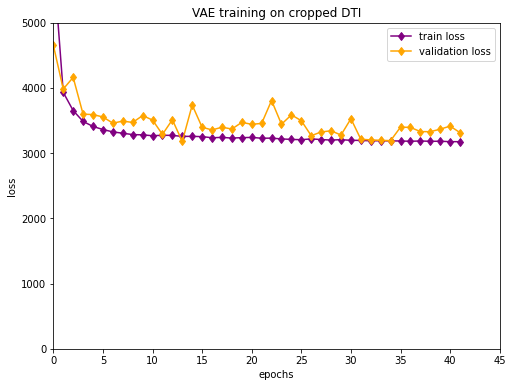

In [5]:
plot_loss(history, xmax = 45, ymax = 5000)

In [ ]:
test_model(model, validation_generator)

## Test on actual bad data

#### Load model

In [1]:
import torch
from torch.utils import data

from Dataset import Dataset
from Models import *
from utils import *
from loss import *
from config import *

import numpy as np
import matplotlib.pyplot as plt
import pickle
import nibabel as nib
from nilearn.plotting import plot_anat

# Load images
def loadb0(img_file, as_type = 'nib', normalize = True, resize = True):
    # as_type should either be nib for nibabel format or np for numpy array
    if as_type not in ['nib', 'np']:
        raise TypeError('Incorrect option for as_type. Use either nib or np.')
    # Load image
    img = nib.load(img_file)
    img_fixed = img.get_fdata()
    # Normalize intensity to range of 0 to 1
    if normalize:
        img_fixed = (img_fixed - np.min(img_fixed, axis = (0,1,2))) / (np.max(img_fixed, axis = (0,1,2)) - np.min(img_fixed, axis = (0,1,2)))
    if resize:
        if img_fixed.shape[0] != 96:
            img_fixed = zoom(img_fixed, (0.75,0.75,1))
    if as_type == 'np':
        return img_fixed
    elif as_type == 'nib':
        # Reform as image data type
        img_fixed = nib.Nifti1Image(img_fixed, np.eye(4))
        return img_fixed

params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0}

#### Reconstruct images

We can either translate the images down 8 voxels which we will reconstruct to maintain the same input size, but we risk cutting off parts of the cerebellum. Alternatively, we can keep the image as is, add 8 voxels of blank voxels, and have the model reconstruct 8 voxels on top of that, but then the input size is different from what the model has trained on.

In [8]:
# dwi_files1 = np.loadtxt('ncanda/X_test_files.txt', dtype=str)
# dwi_files2 = np.loadtxt('ncanda/X_nonb0_test.txt', dtype=str)
# dwi_files_npy = np.concatenate((dwi_files1, dwi_files2))
dwi_files_npy = np.loadtxt('ncanda/X_test_files.txt', dtype=str)
target_files = np.loadtxt('ncanda/fixed_file_locations.txt', dtype=str)
test_set = Dataset(dwi_files_npy, corrupt_prob = 0)
test_generator = data.DataLoader(test_set, **params)

model = torch.load('models/ncanda_nonb0/Epoch_35_Train_loss_3186.9375_Test_loss_3191.2046.pth')
print(model)

VQVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): VectorQuantizerEMA(
    (_embedding): Embedding(512, 32)
  )
  (decoder): VQDecoder_skip(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): ConvTranspose3d(128, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): ConvTrans

In [9]:
from scipy.ndimage import shift, zoom

def add_translation(image3d, amount, axis):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
        
    shift_apply = np.zeros((3,))
    shift_apply[axis] = amount
    # Apply translation
    img_translated = shift(img, shift_apply)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img_translated = nib.Nifti1Image(img_translated, np.eye(4))
        
    return img_translated

translate = True

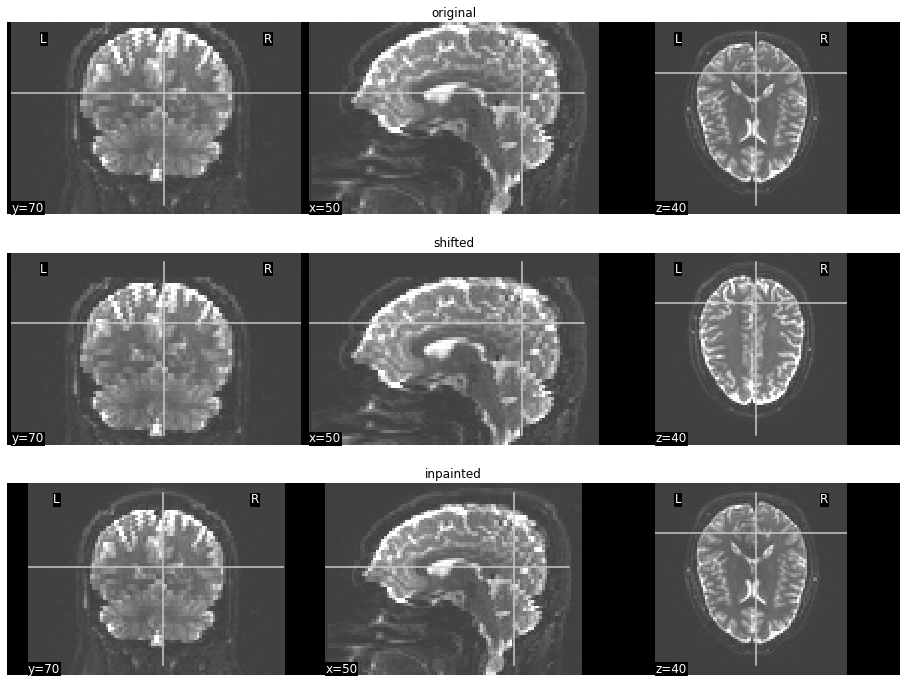

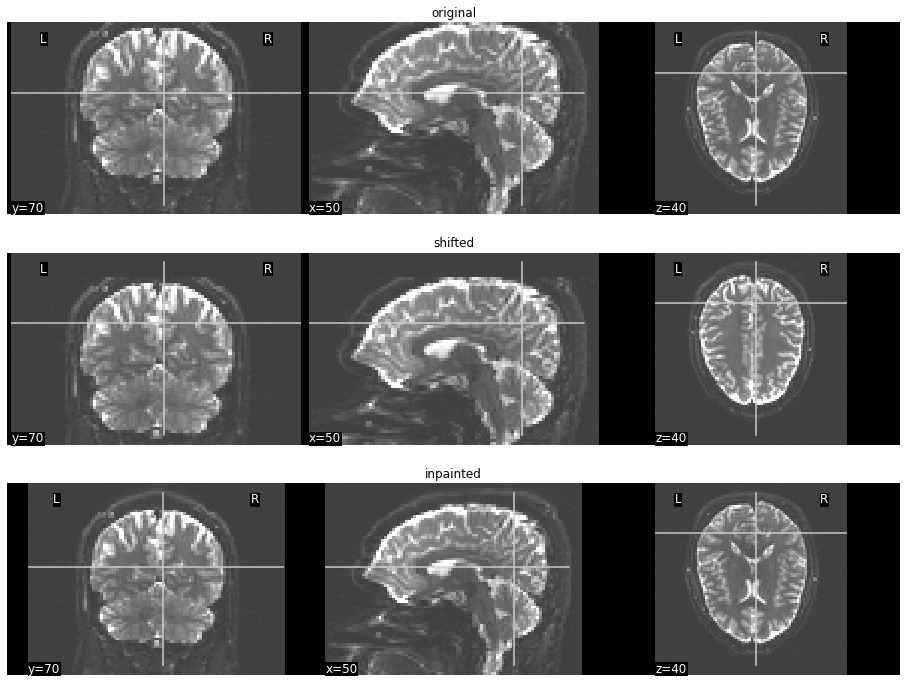

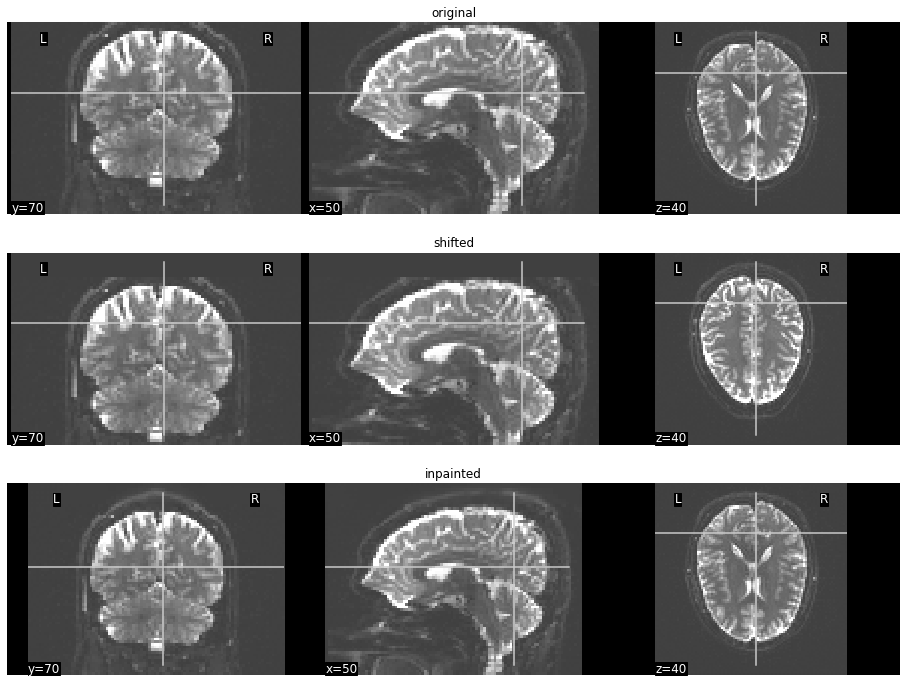

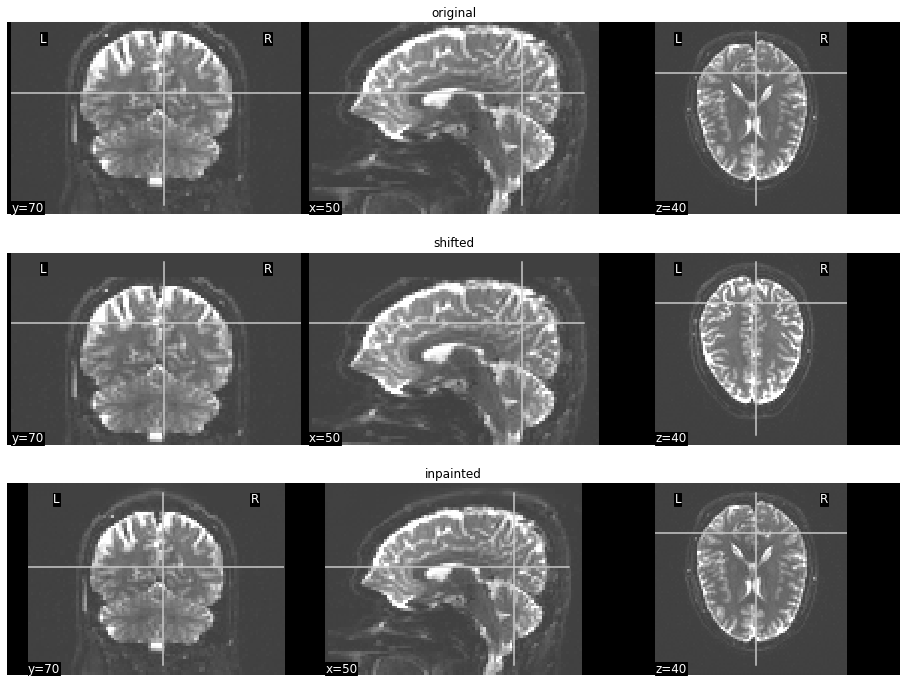

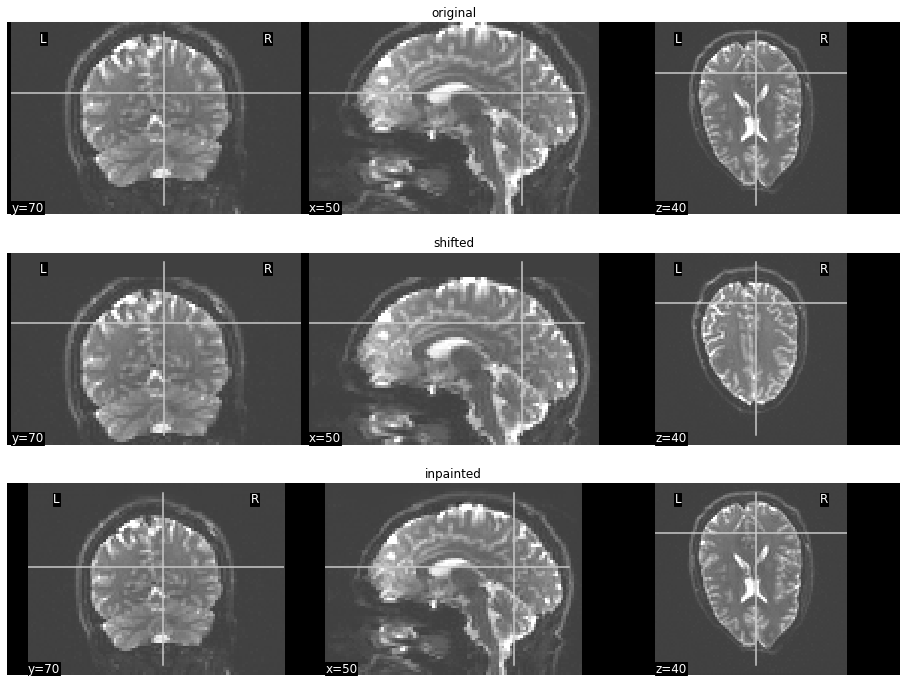

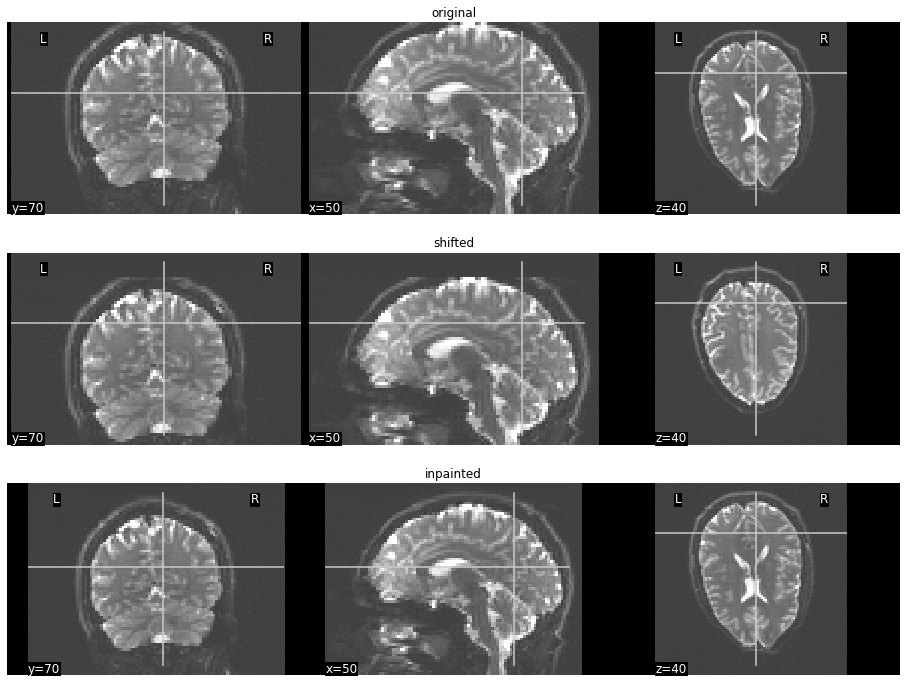

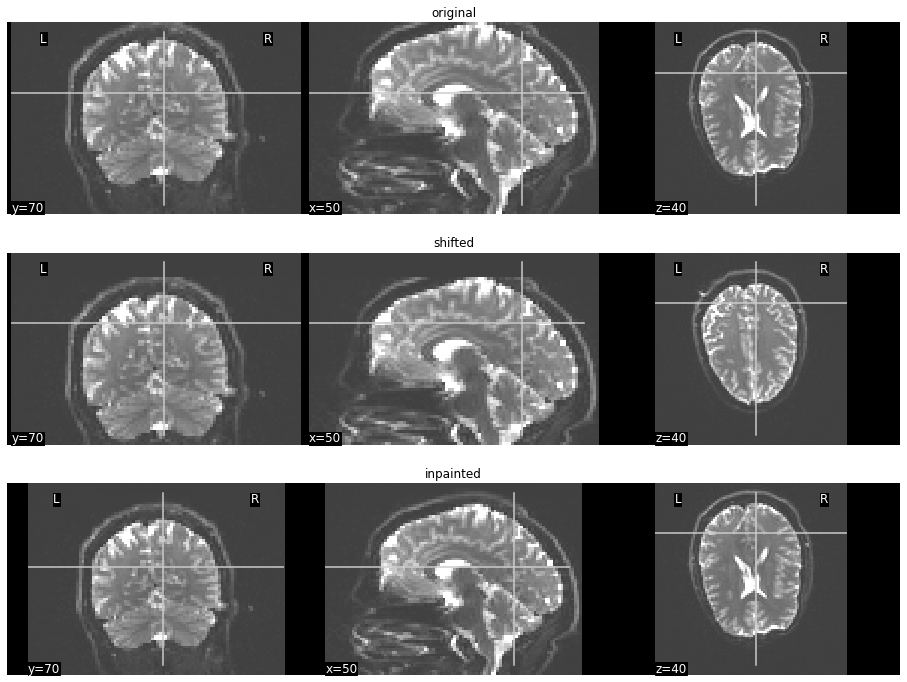

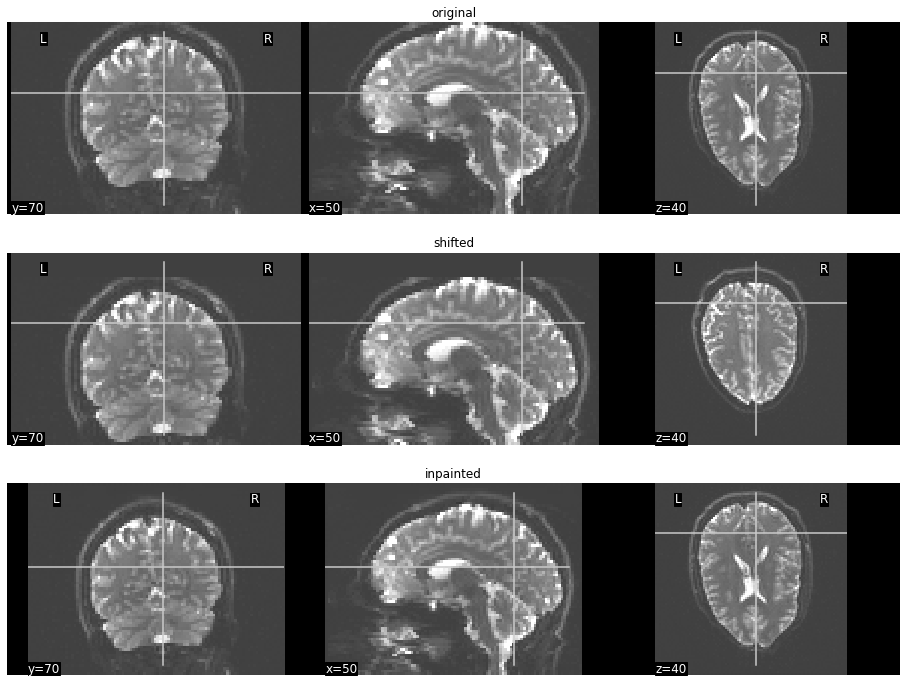

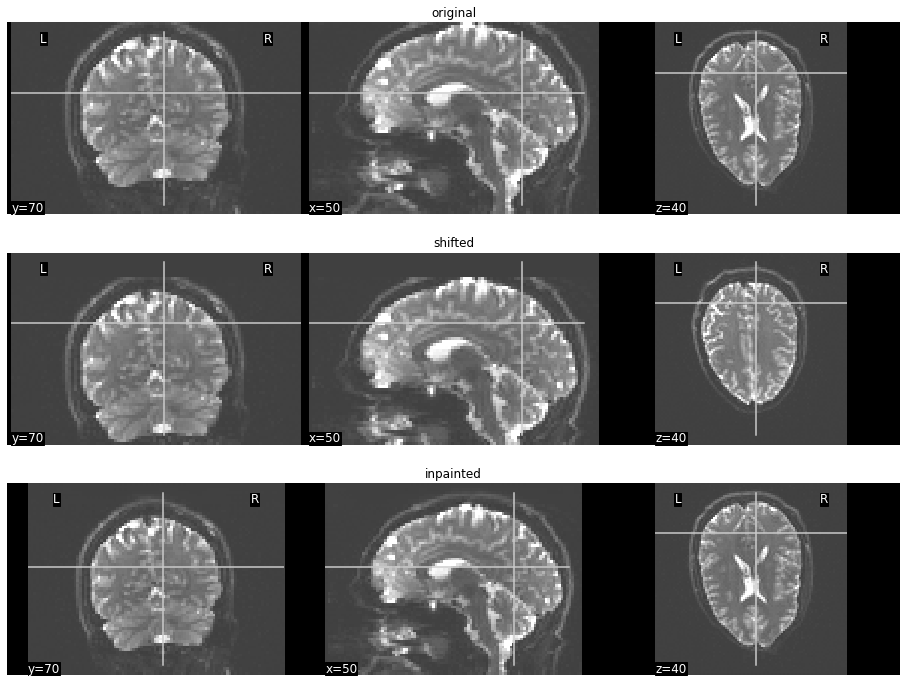

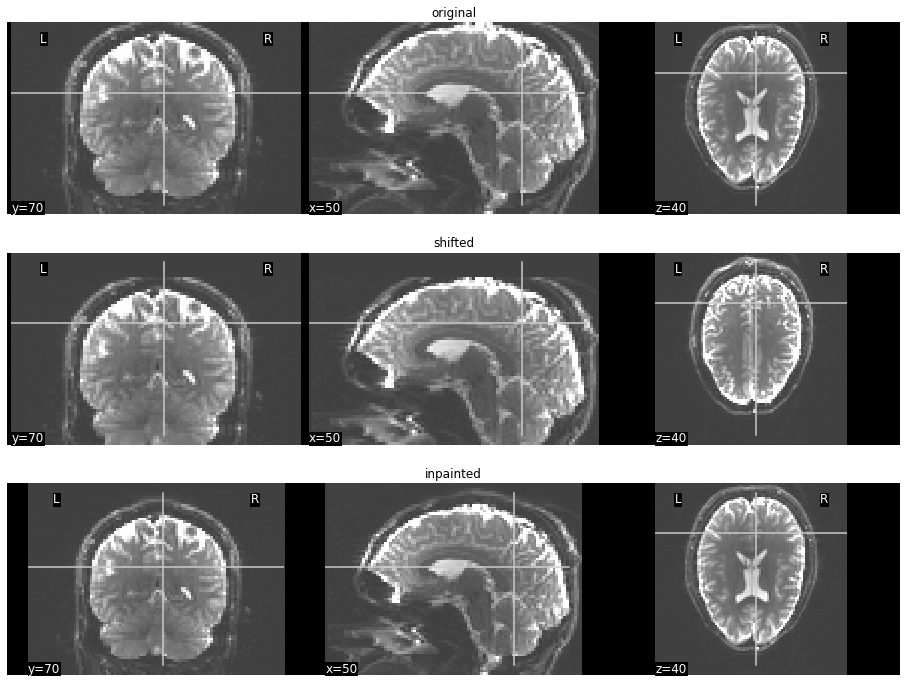

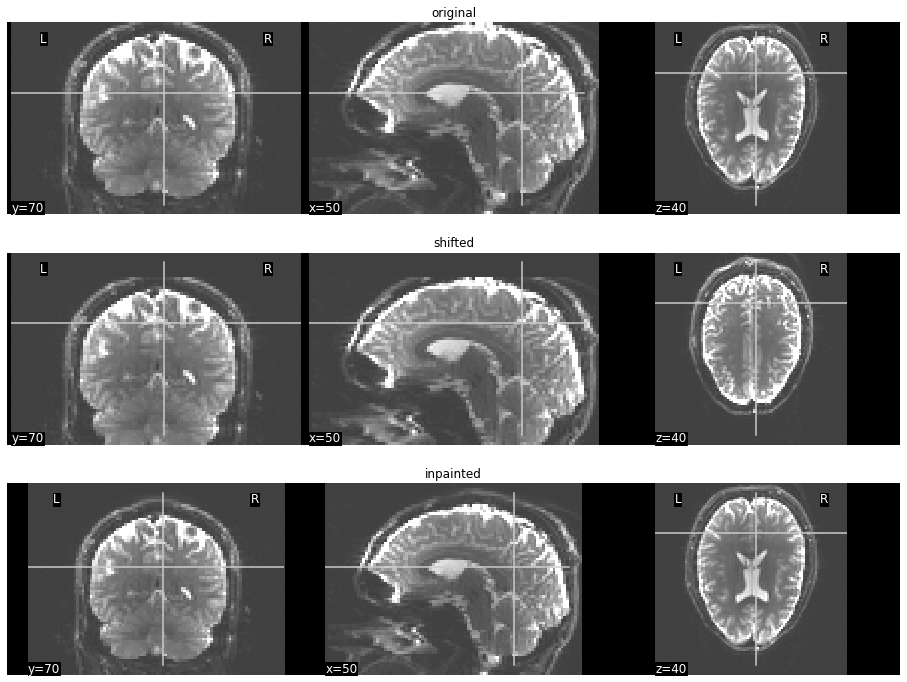

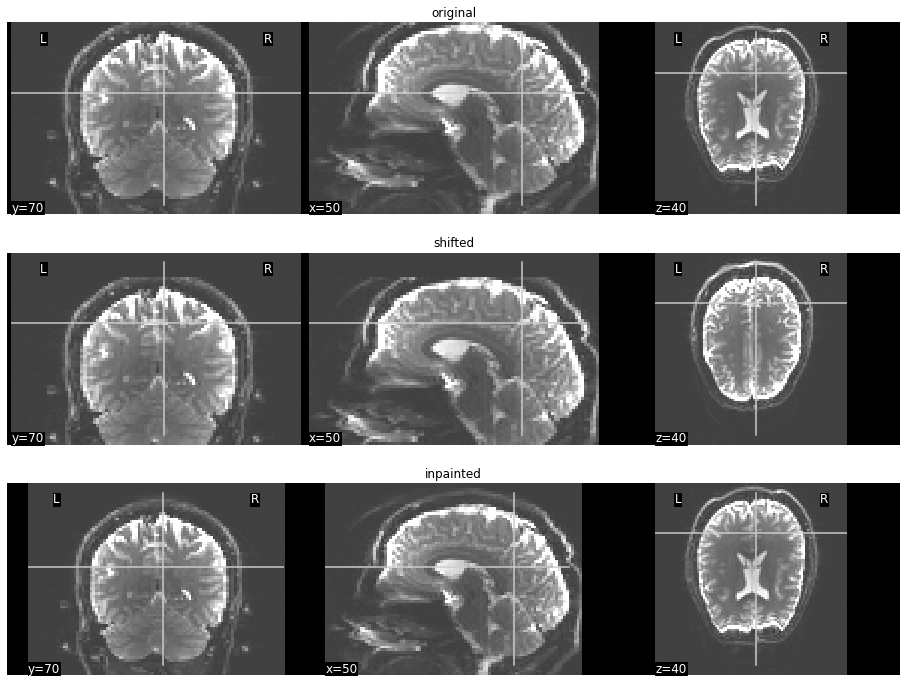

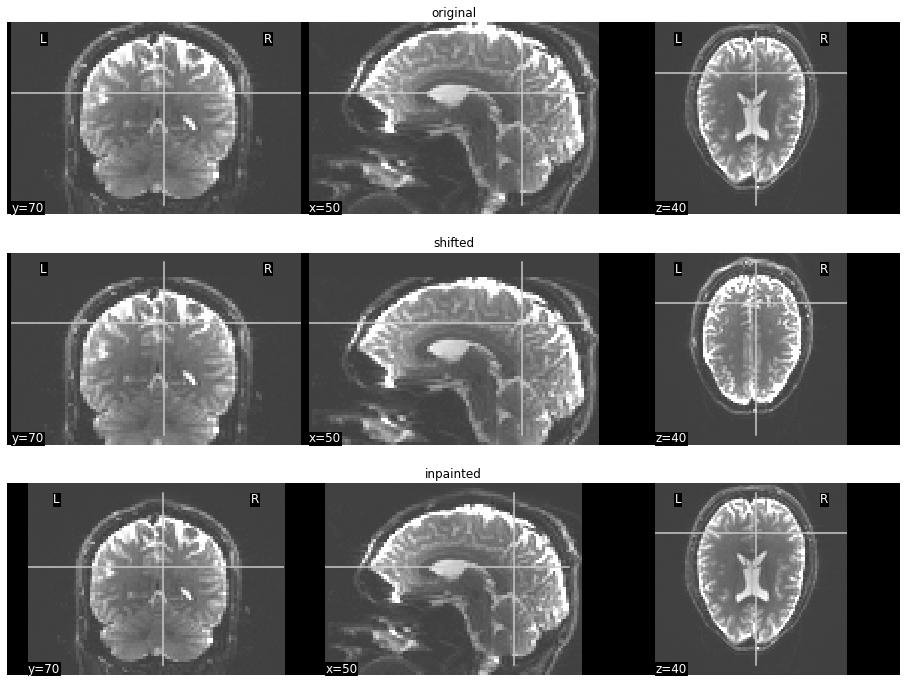

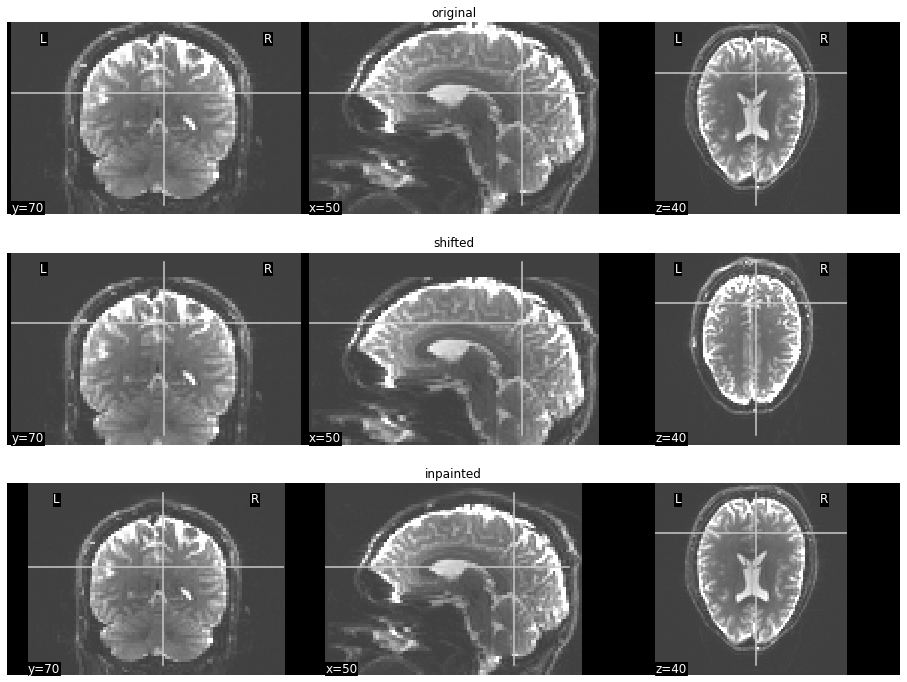

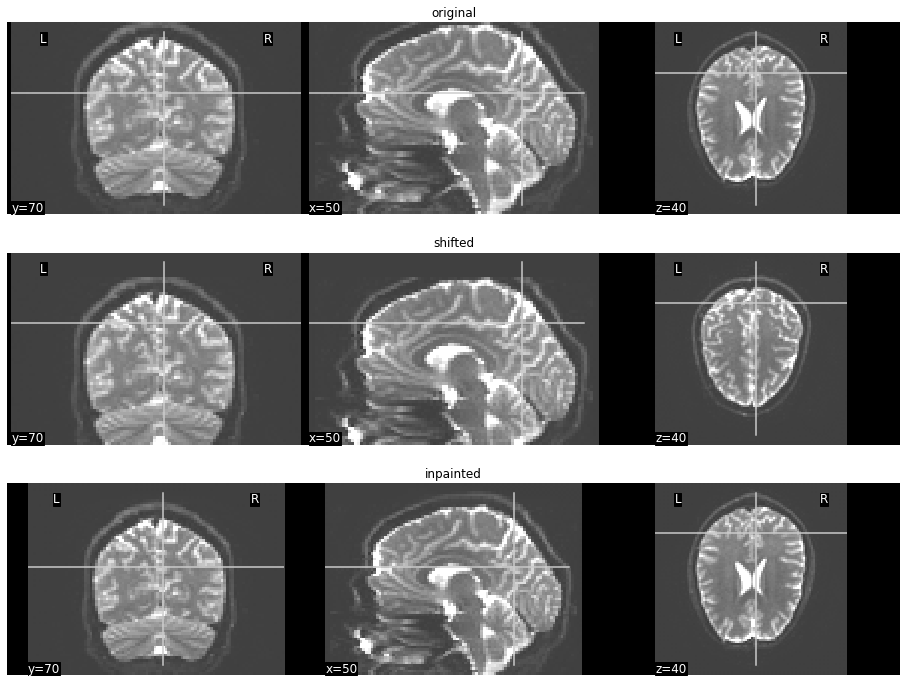

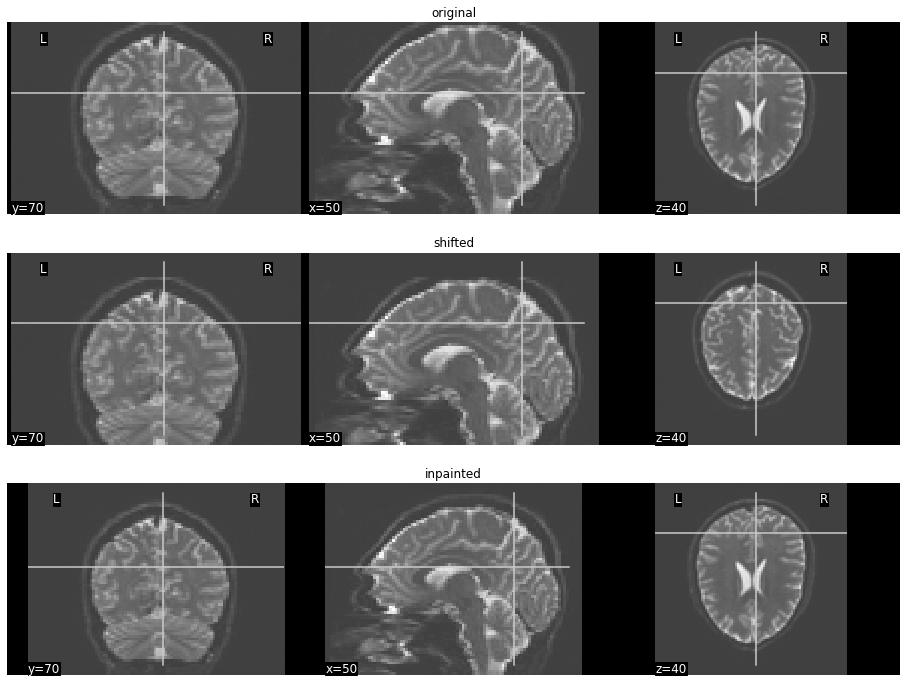

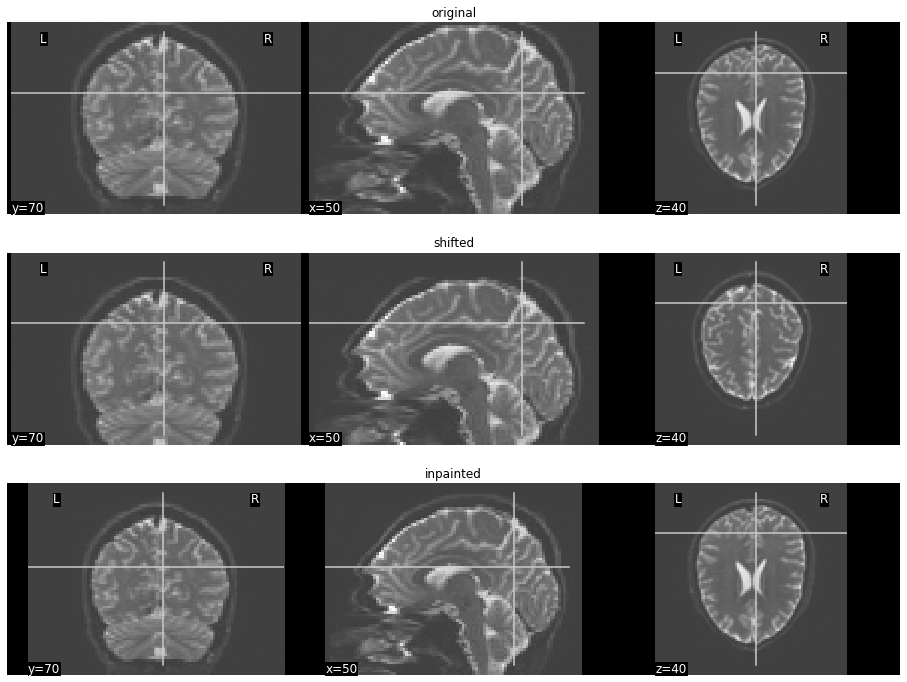

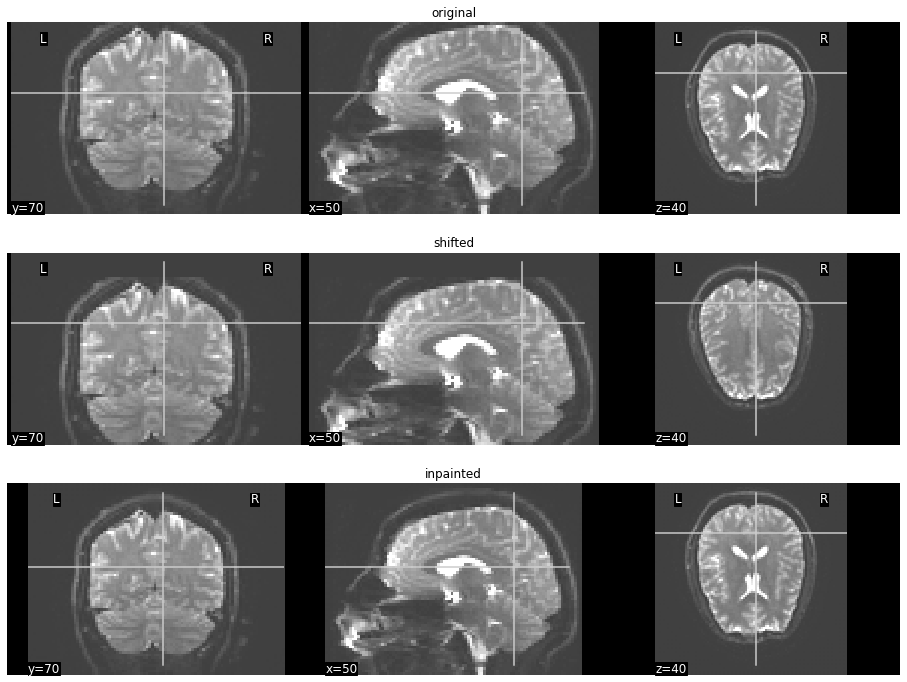

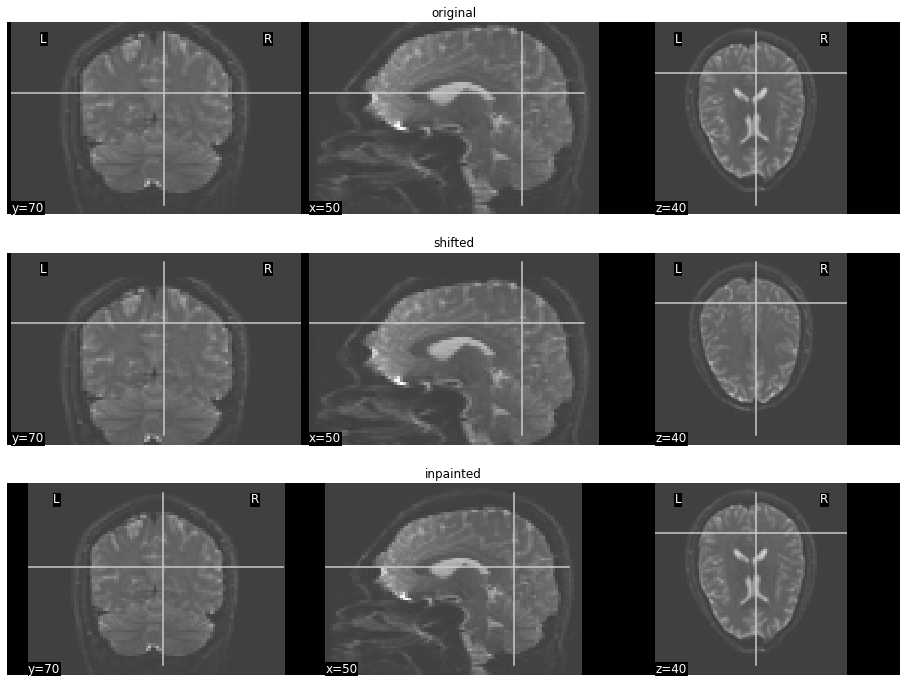

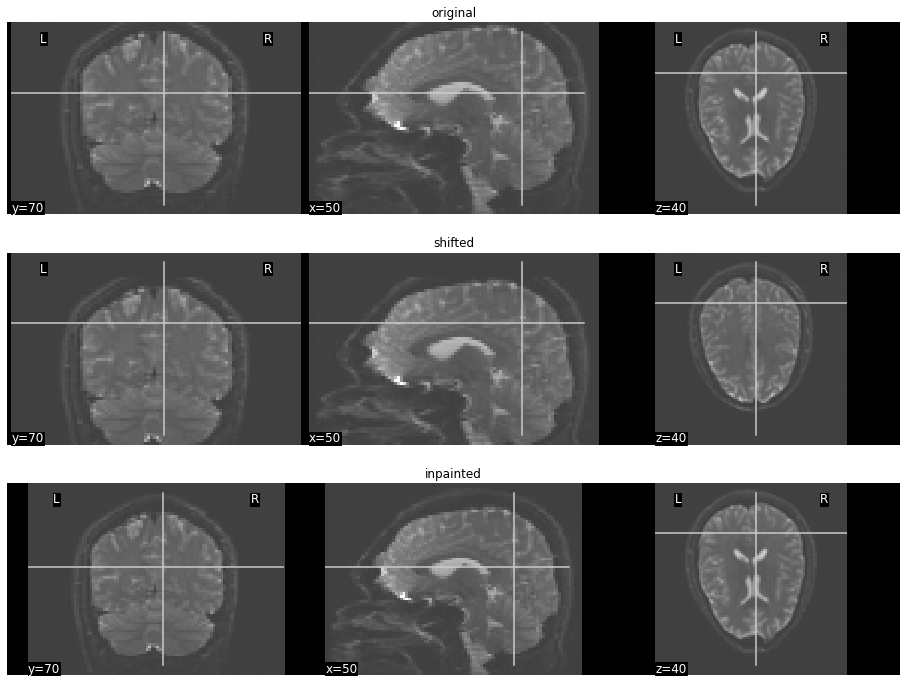

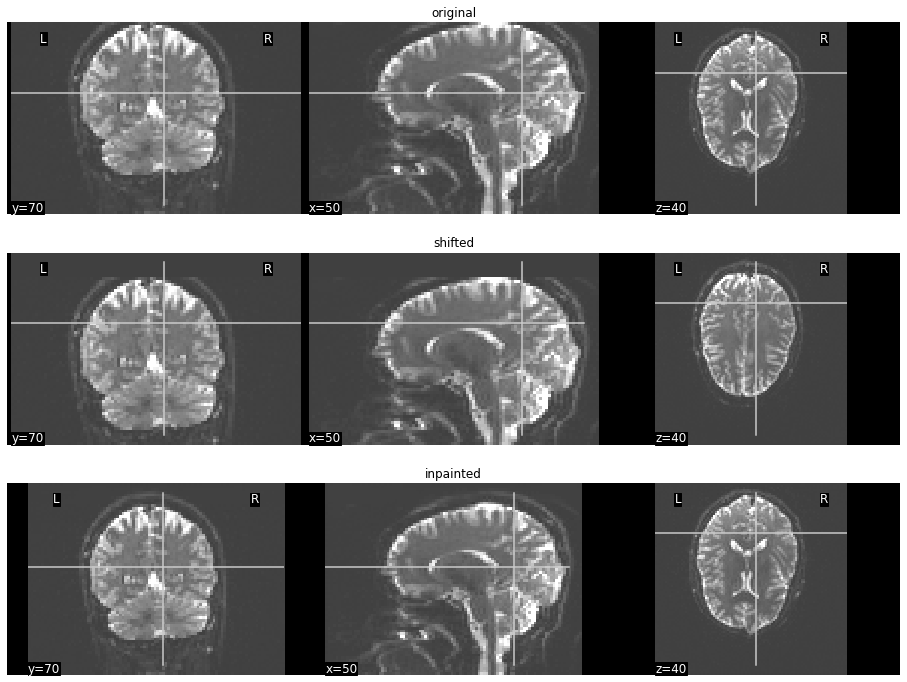

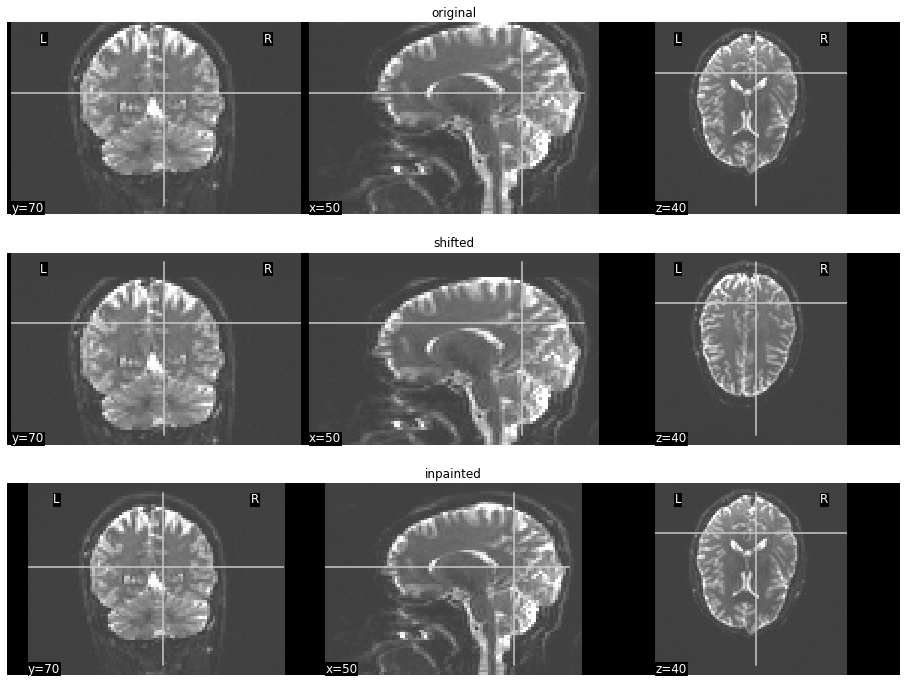

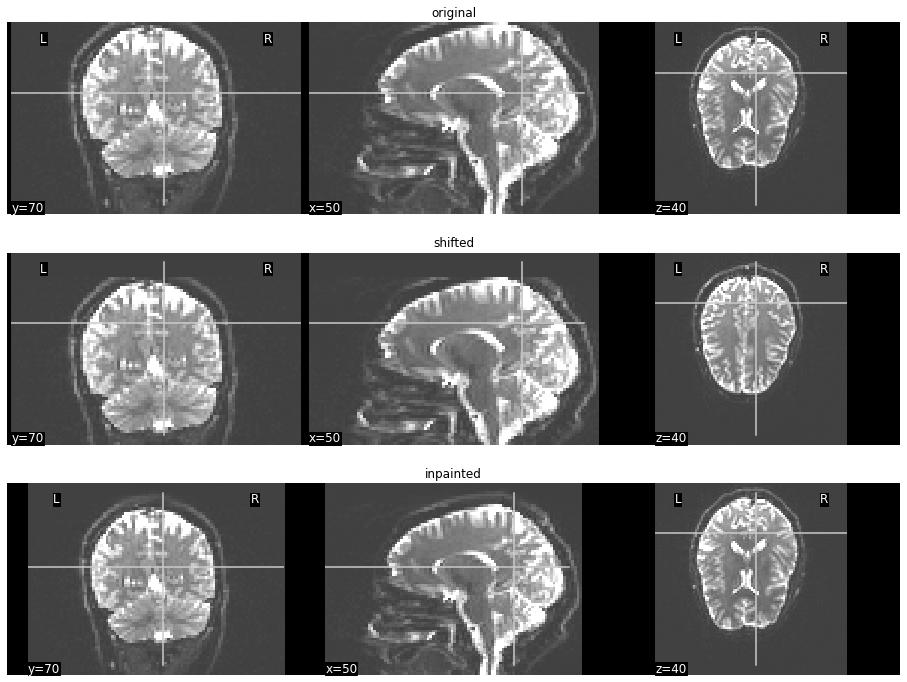

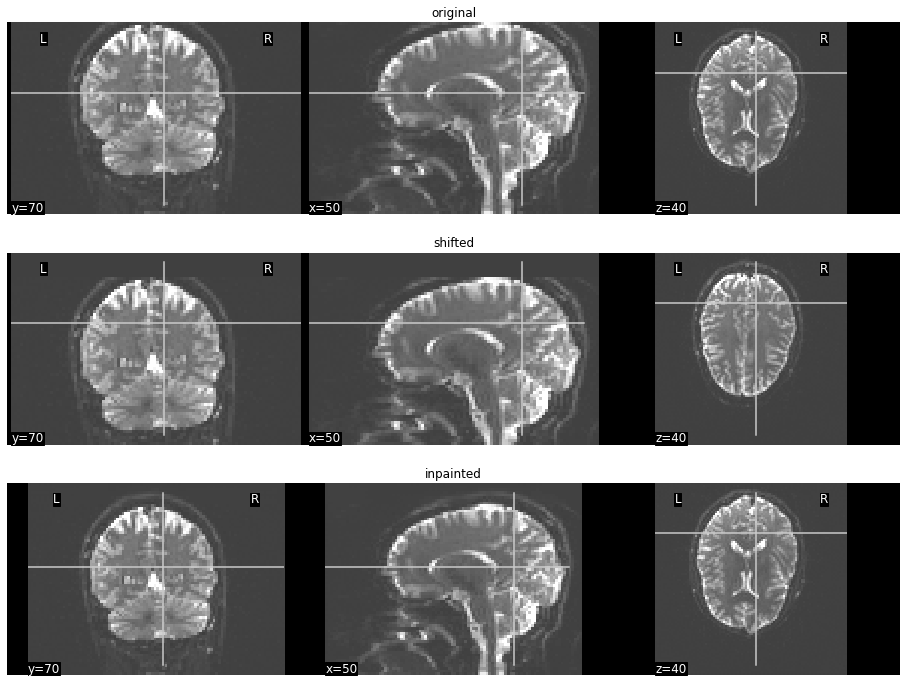

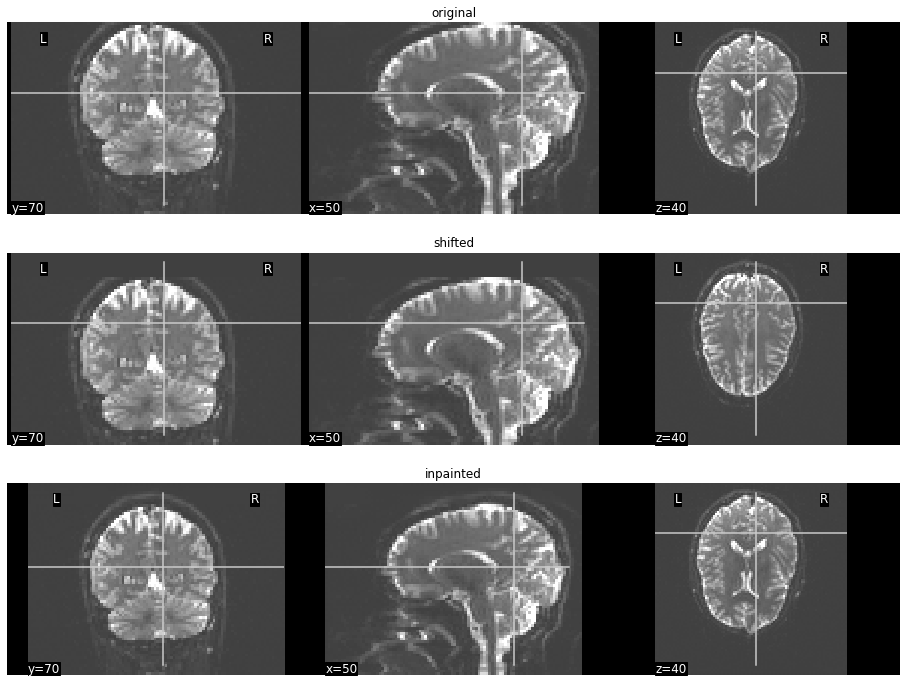

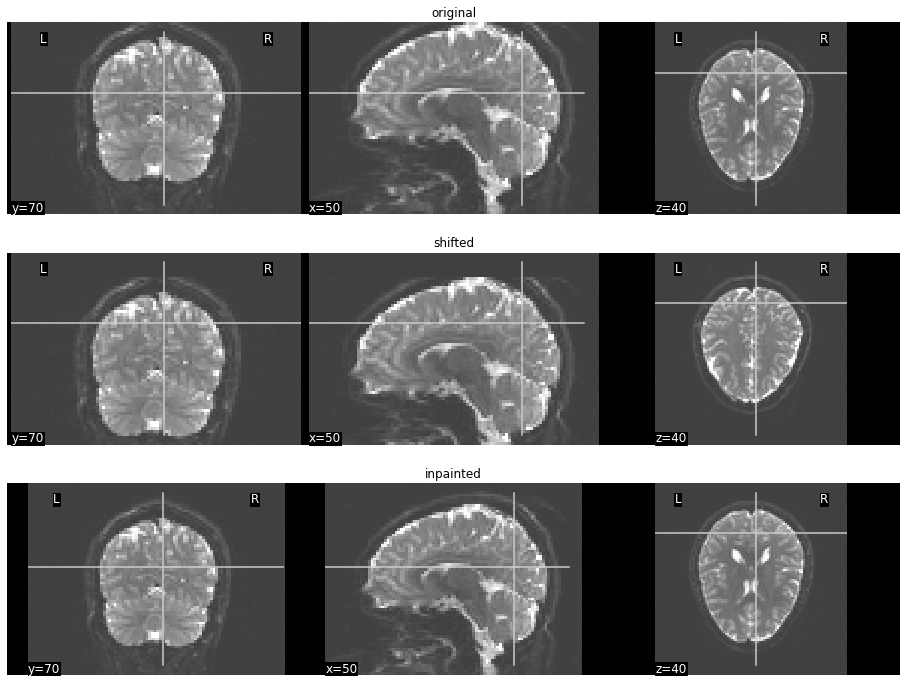

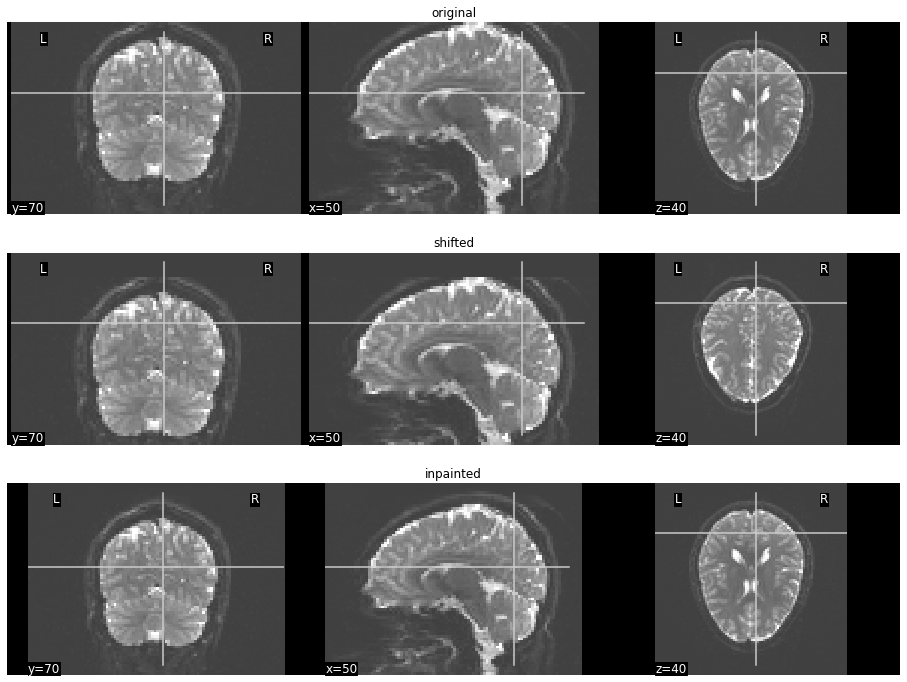

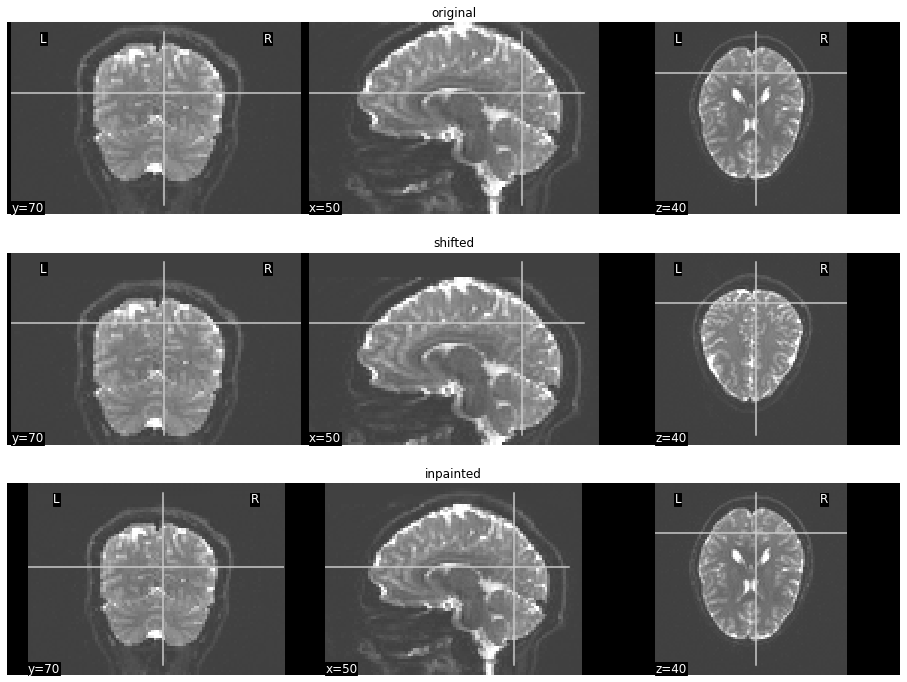

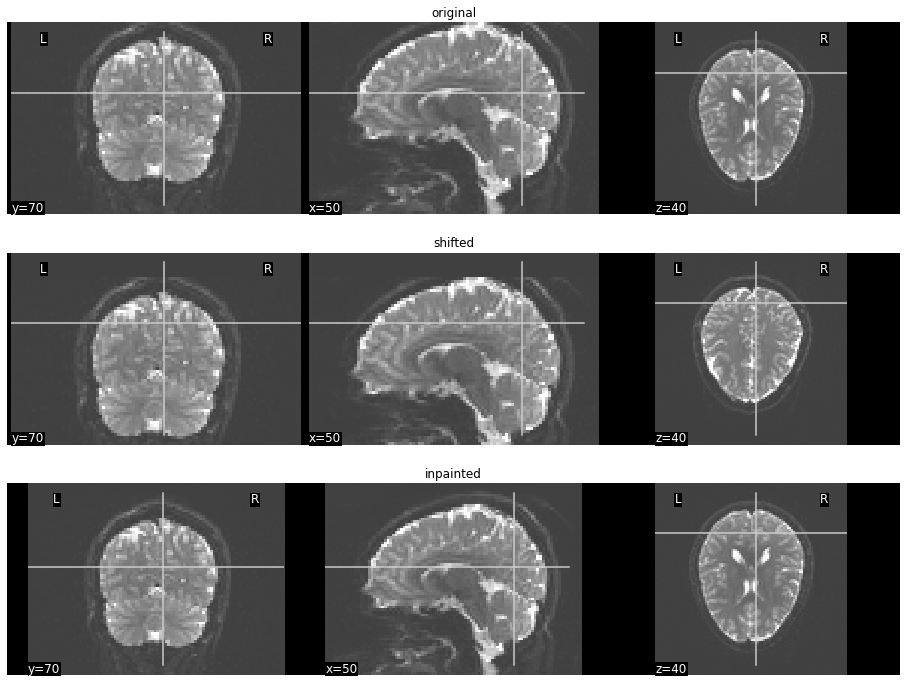

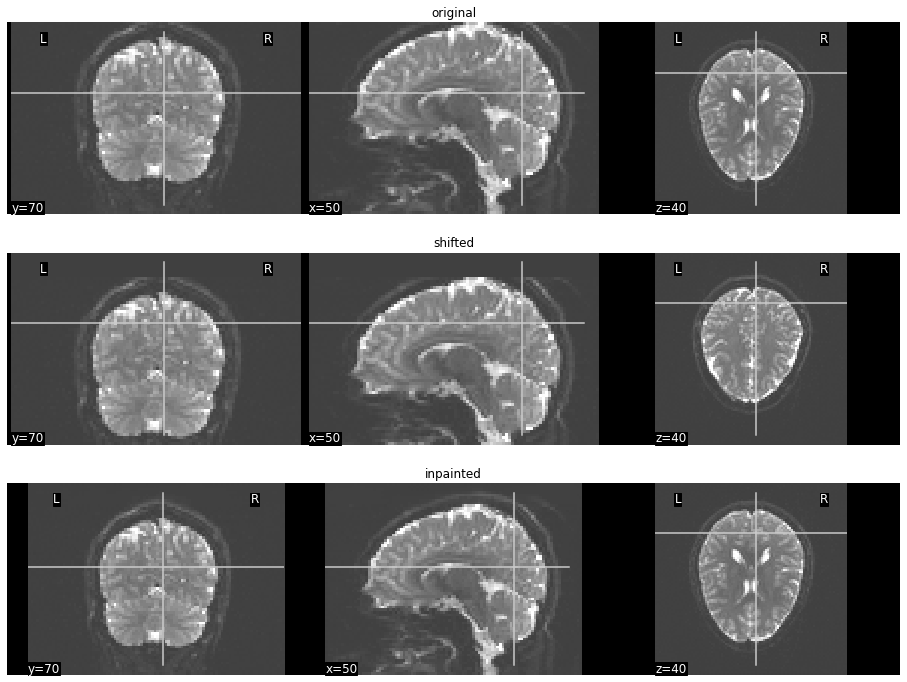

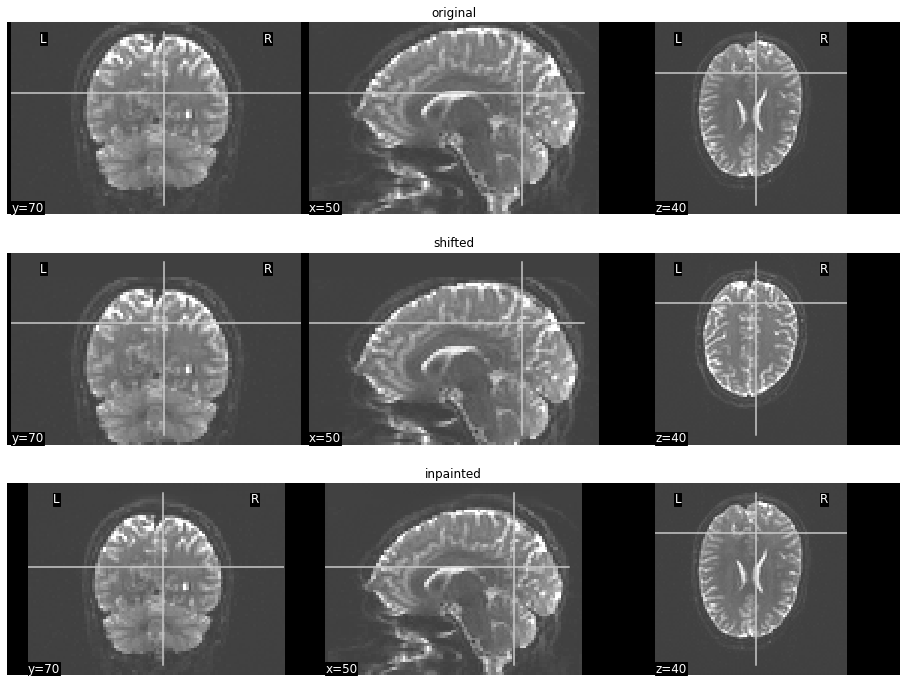

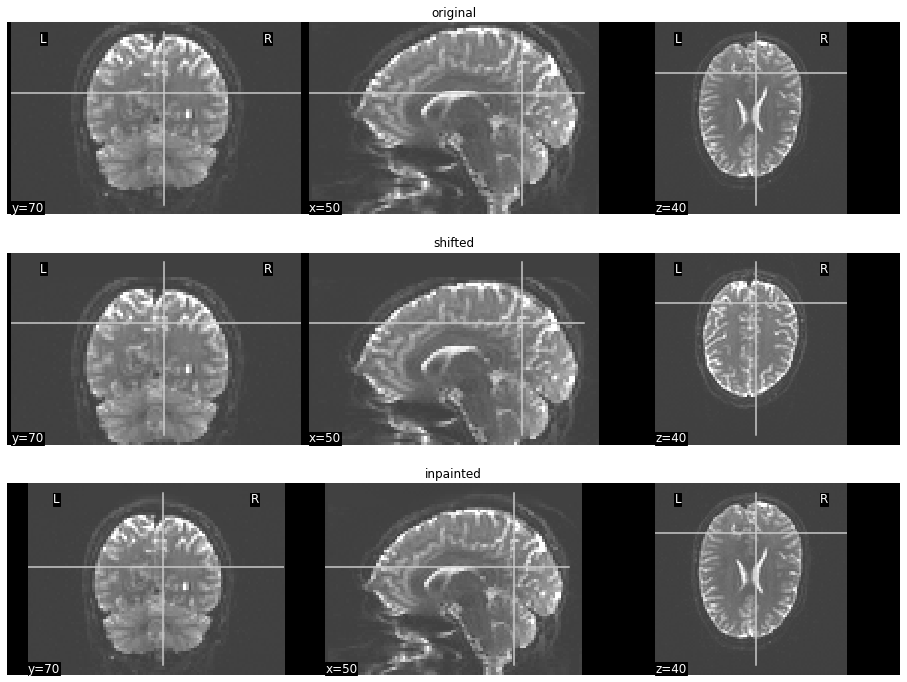

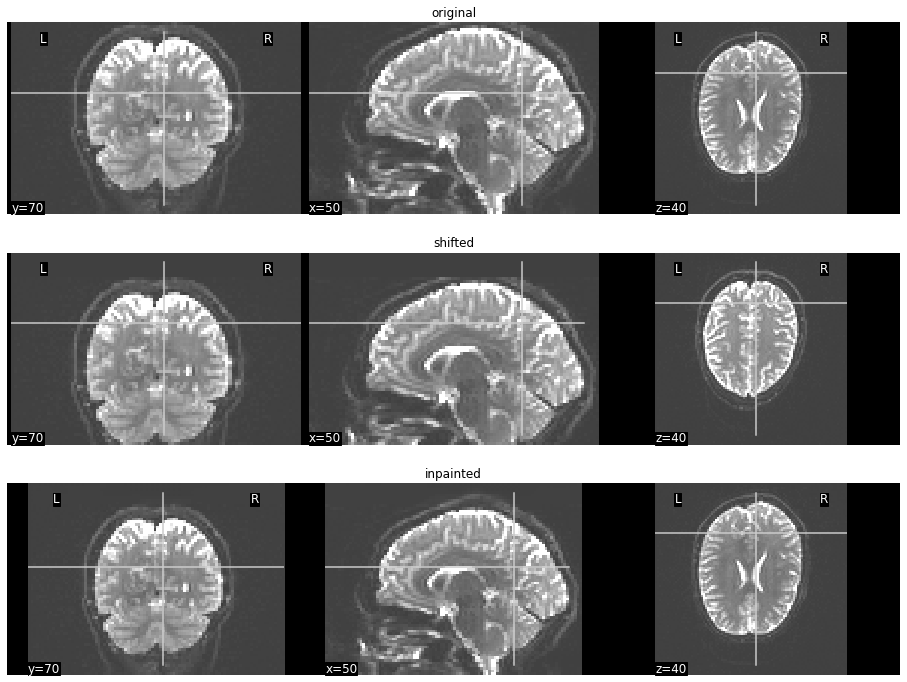

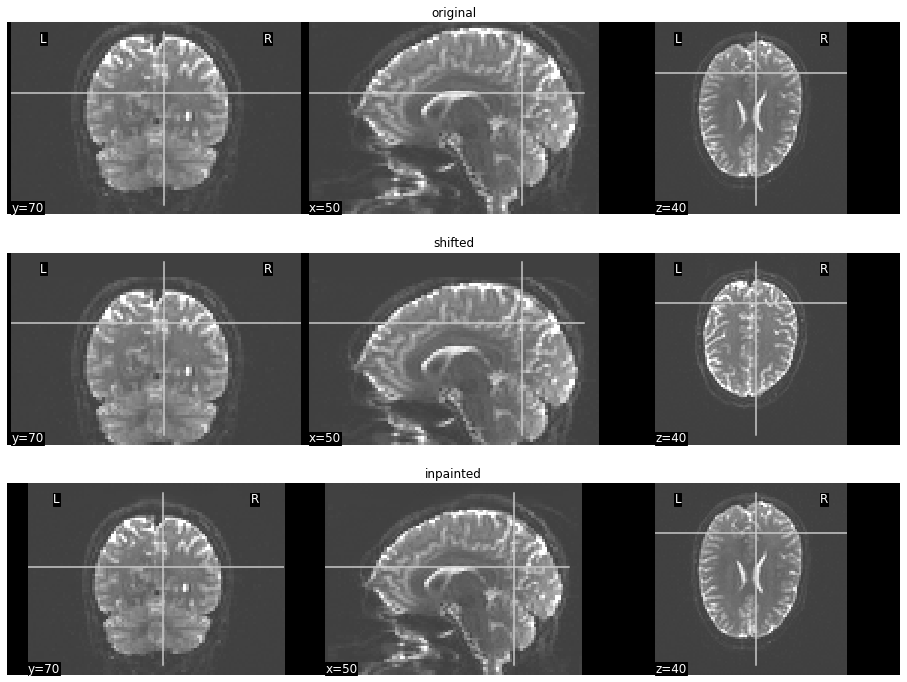

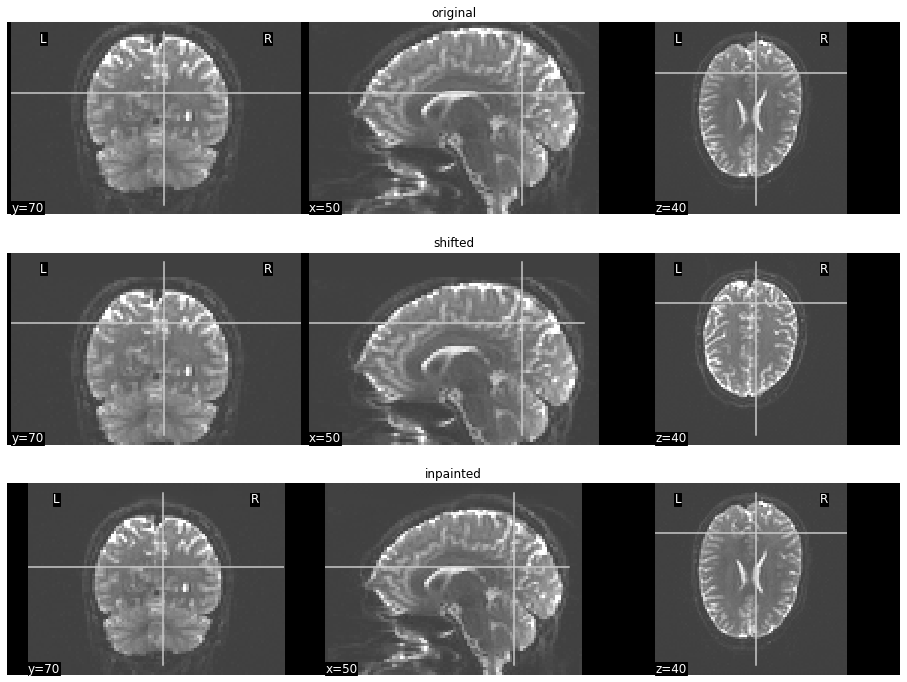

In [18]:
model.eval()
model.to('cpu')
num_plot = 10
i = 0
for ind, (dwi_in, dwi_out) in enumerate(test_generator):
    dwi_in = dwi_in.detach().numpy().squeeze()
    # Translate image down
    if translate:
        cutoff = dwi_in[:,:,:8]
        dwi_shift = add_translation(dwi_in, -8, 2)
        dwi_shift = torch.from_numpy(dwi_shift).view(1,1,dwi_shift.shape[0],dwi_shift.shape[1],dwi_shift.shape[2])
    # Otherwise, pad and resize
    else:
        dwi_shift = zoom(dwi_in, (1,1,0.875)) # Go from 64 to 56 in z dimension
        dwi_shift = np.pad(dwi_shift, ((0,0),(0,0),(0,8)))
        print(dwi_shift.shape)
        dwi_shift = torch.from_numpy(dwi_shift).view(1,1,dwi_shift.shape[0],dwi_shift.shape[1],dwi_shift.shape[2])
    _, plot_recon, _ = model(dwi_shift)
    dwi_recon = plot_recon.detach().numpy().squeeze()
    if translate:
        dwi_recon = np.concatenate((cutoff, dwi_recon), axis = 2)
    dwi_shift = dwi_shift.detach().numpy().squeeze()
    dwi_recon = nib.Nifti1Image(dwi_recon, np.eye(4))
    dwi_in = nib.Nifti1Image(dwi_in, np.eye(4))
    dwi_shift = nib.Nifti1Image(dwi_shift, np.eye(4))

    plt.close('all')
    fig, ax = plt.subplots(3,1,figsize = (16,12))
    plot_anat(dwi_in, axes = ax[0], vmin = -0.1, vmax = 0.3, cut_coords = (50,70,40))
    plot_anat(dwi_shift, axes = ax[1], vmin = -0.1, vmax = 0.3, cut_coords = (50,70,40))
    plot_anat(dwi_recon, axes = ax[2], vmin = -0.1, vmax = 0.3, cut_coords = (50, 70, 40))
    
    ax[0].set_title('original')
    ax[1].set_title('shifted')
    ax[2].set_title('inpainted')
    plt.show()
    i += 1
    
    target_dir = '/'.join(target_files[ind].split('/')[:-1])
    if not os.path.isdir(target_dir):
        os.makedirs(target_dir)
    nib.save(dwi_recon, target_files[ind])
    #if i == num_plot: break

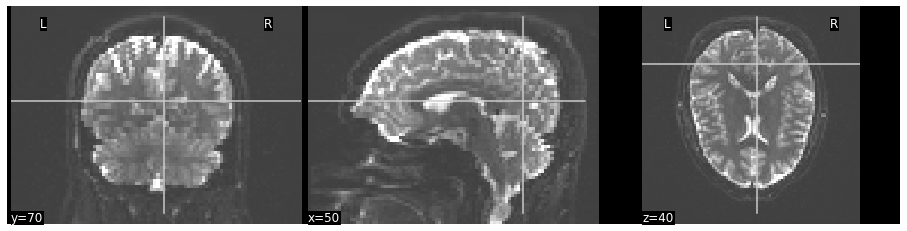

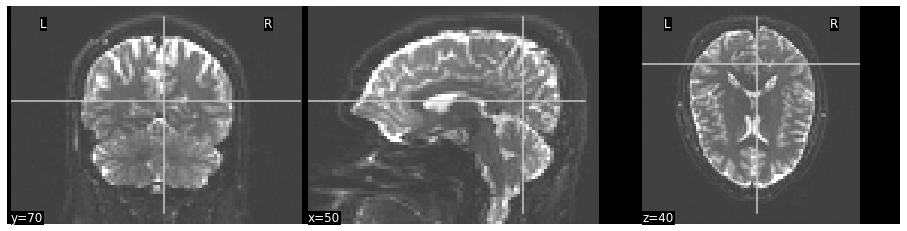

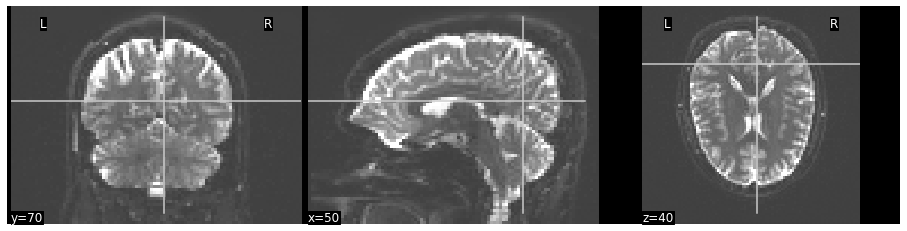

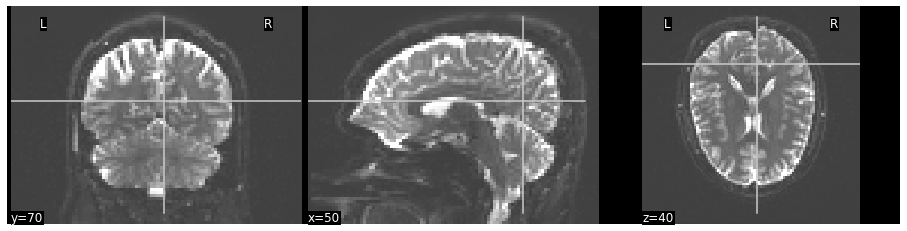

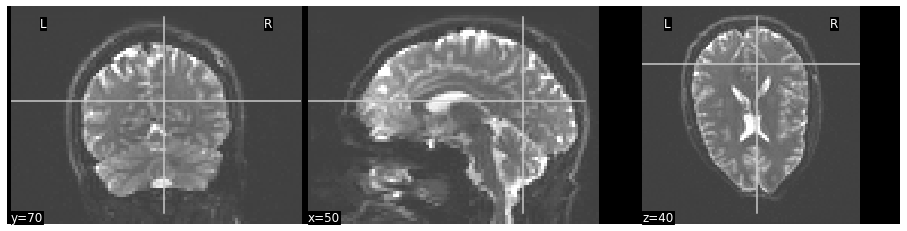

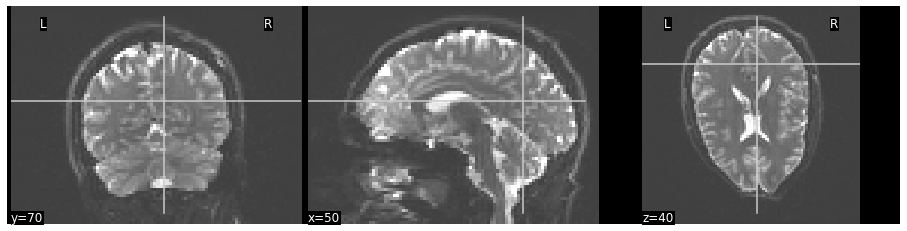

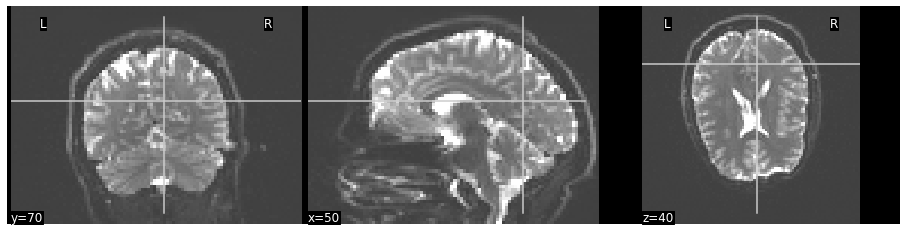

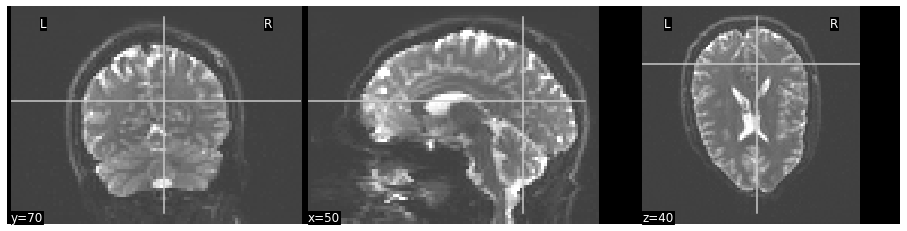

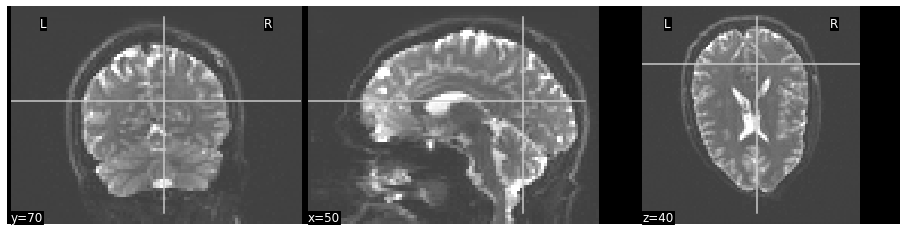

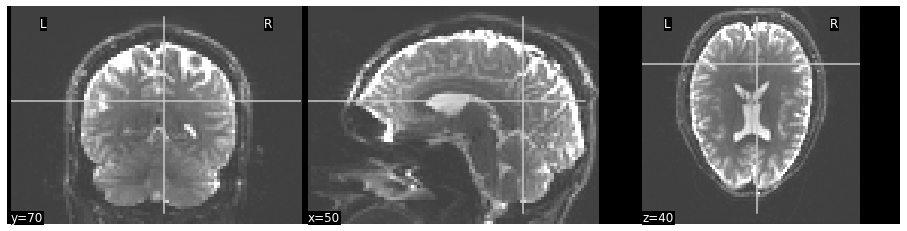

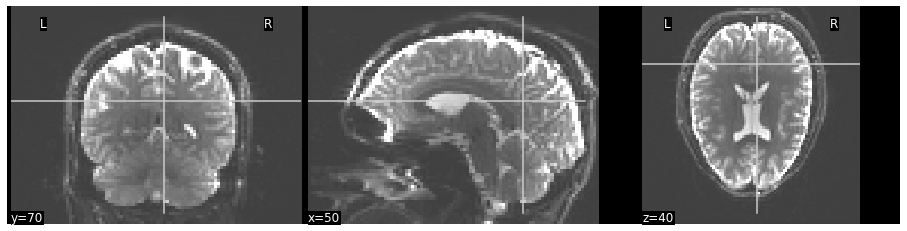

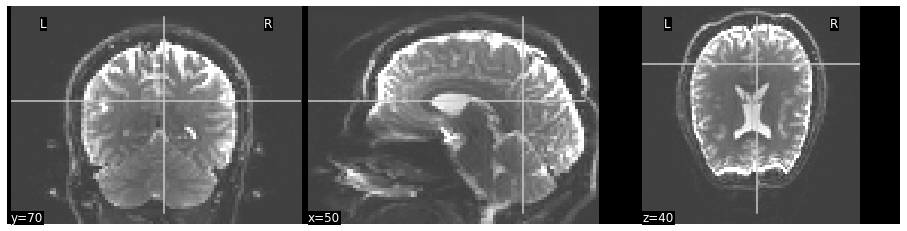

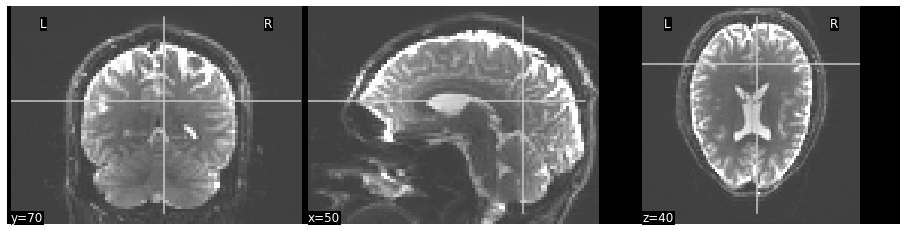

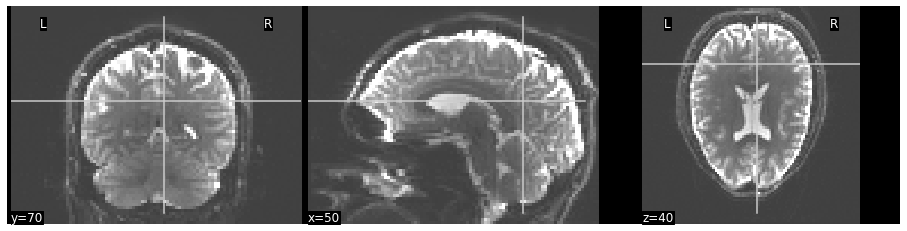

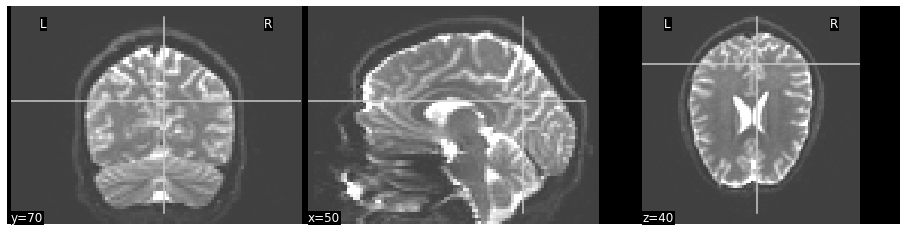

KeyboardInterrupt: 

In [20]:
for file in target_files:
    img = nib.load(file)
    plt.close('all')
    fig, ax = plt.subplots(1,1,figsize = (16,4))
    plot_anat(img, axes = ax, vmin = -0.1, vmax = 0.3, cut_coords = (50,70,40))
    plt.show()

## Compare models

In [1]:
import torch
from torch.utils import data

from Dataset import Dataset
from Models import *
from utils import *
from loss import *
from config import *

import numpy as np
import matplotlib.pyplot as plt
import pickle
import nibabel as nib
from nilearn.plotting import plot_anat
from skimage.metrics import structural_similarity

batch_size = 128
num_plot = 6
cpu_batch_load_workers = 8
train_corrupt_prob = 1.0
valid_corrupt_prob = 1.0
num_corrupt = 8

params = {'batch_size': batch_size,
          'shuffle': False,
          'num_workers': cpu_batch_load_workers}
    
# dwi_files_npy = np.loadtxt('ncanda/X_files.txt', dtype=str)
dwi_files1 = np.loadtxt('ncanda/X_files.txt', dtype=str)
dwi_files2 = np.loadtxt('X_resized_files.txt', dtype=str)
dwi_files_npy = np.concatenate((dwi_files1, dwi_files2))
np.random.seed(420)
np.random.shuffle(dwi_files_npy)
num_train = int(0.8 * dwi_files_npy.shape[0])

validation_set = Dataset(dwi_files_npy[num_train:], corrupt_prob = valid_corrupt_prob, num_corrupt = num_corrupt)
validation_generator = data.DataLoader(validation_set, **params)

input_shape = (1,96,96,64)

#### Plot losses

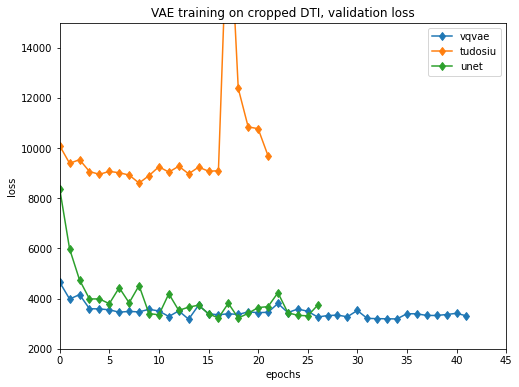

In [2]:
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax.set_xlim([0,45])
ax.set_ylim([2000,15000])
ax.set_title('VAE training on cropped DTI, validation loss')

for modelname in ['ncanda_nonb0', 'tudosiu', 'unet']:
    with open('models/' + modelname + '/history.p', 'rb') as f:
        history = pickle.load(f)
    ax.plot(history['test'], '-d')

ax.legend(['vqvae', 'tudosiu', 'unet'])
plt.show()

#### Evaluate performance on validation set with SSIM

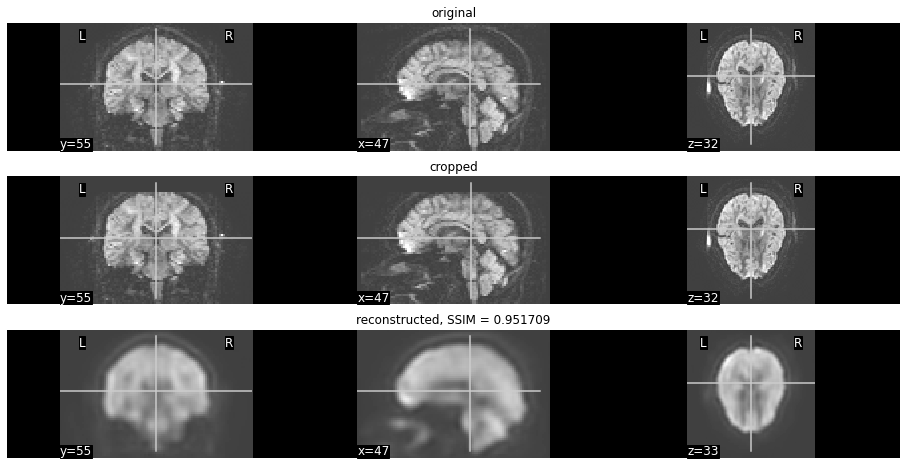

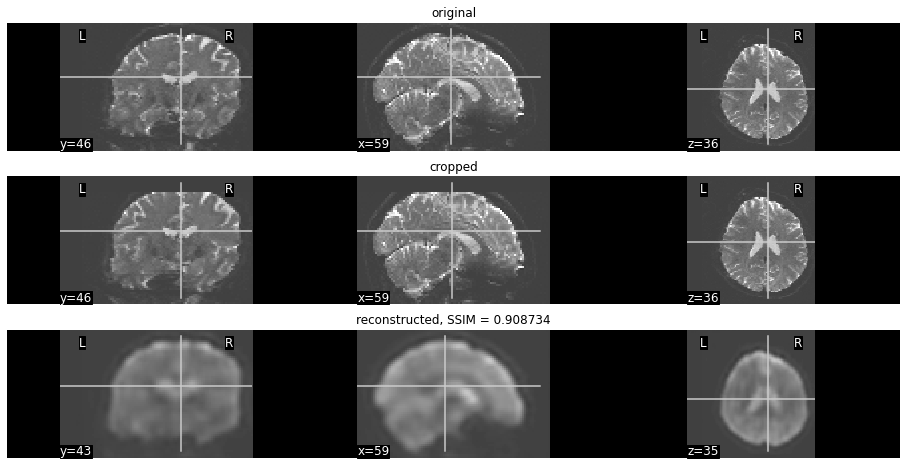

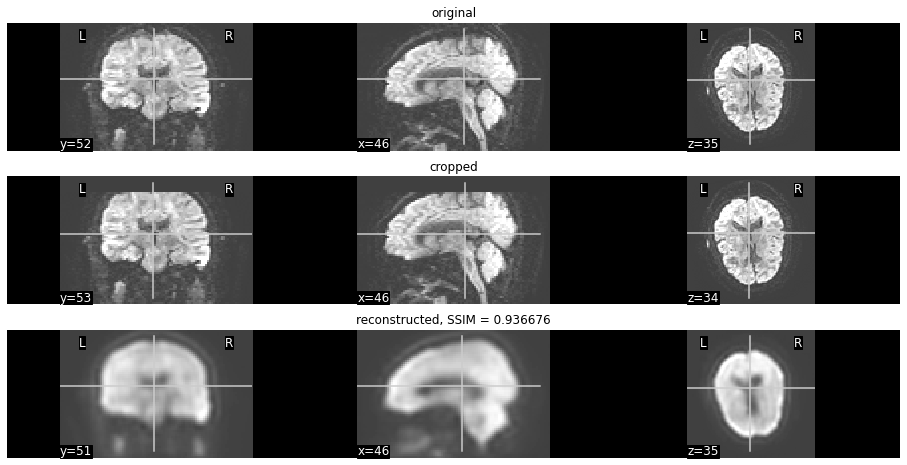

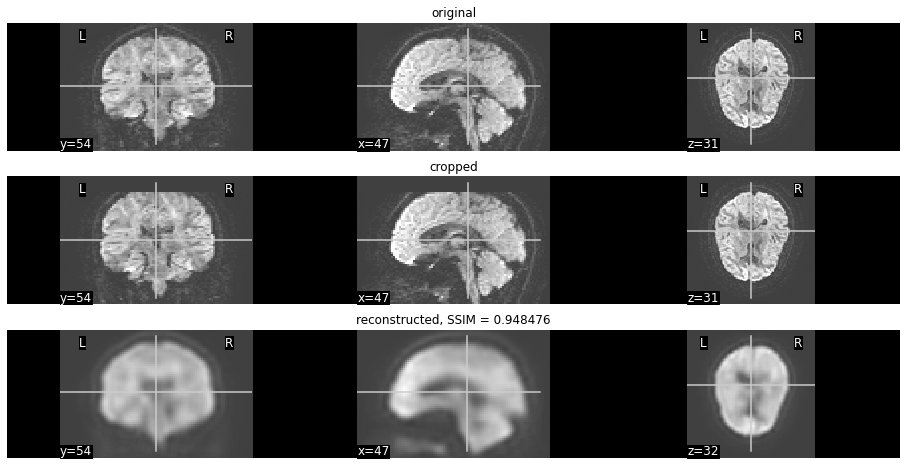

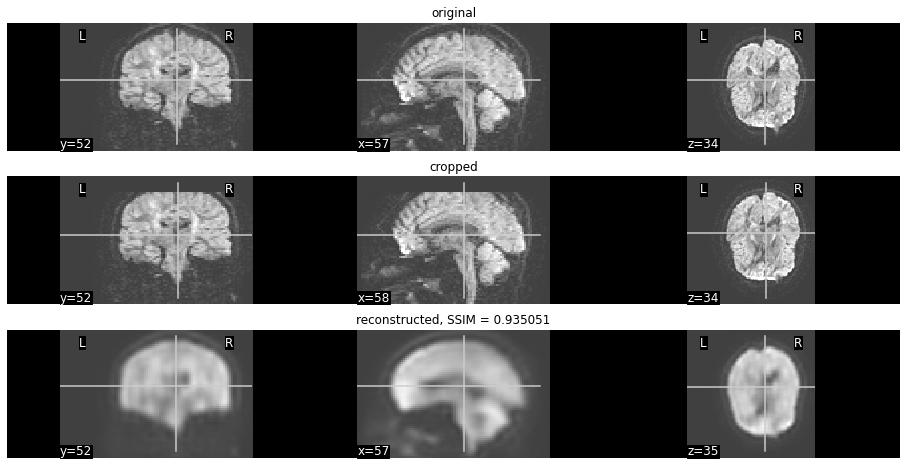

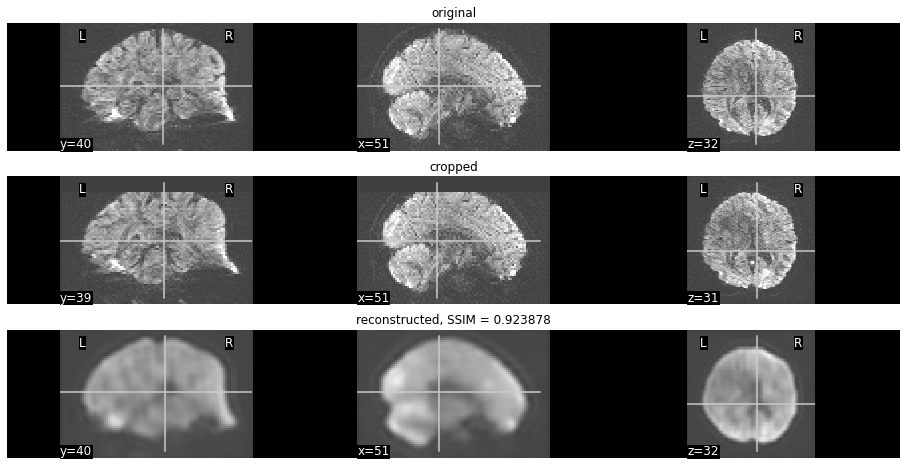

Average SSIM: 0.926713
STD SSIM: 0.025051


In [2]:
paths = ['models/ncanda_nonb0/Epoch_35_Train_loss_3186.9375_Test_loss_3191.2046.pth',
         'models/unet/Epoch_19_Train_loss_3390.7967_Test_loss_3225.1500.pth',
         'models/tudosiu/Epoch_14_Train_loss_8893.6786_Test_loss_8974.4252.pth']

ssim_means = []
ssim_stds = []
plot_batch_in, plot_batch_out = next(iter(validation_generator))
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

for ind,modelname in enumerate(paths[2:]):
    torch.cuda.empty_cache()
    plot_batch_in, plot_batch_out = plot_batch_in.to(device), plot_batch_out.to(device)
    model = torch.load(modelname)
    model.eval()
    model.to(device)
    if ind == 1:
        plot_recon = model(plot_batch_in)
    else:
        _, plot_recon, _ = model(plot_batch_in)

    x_recon = plot_recon.cpu().detach().numpy().squeeze()
    x_corr = plot_batch_in.cpu().detach().numpy().squeeze()
    x_clean = plot_batch_out.cpu().detach().numpy().squeeze()

    ssim_orig2recon = [structural_similarity(x_clean[i][:,:,-16:], x_recon[i][:,:,-16:], data_range = 1) for i in range(batch_size)]

    for i in range(num_plot):
        plt.close('all')
        fig,ax = plt.subplots(3,1,figsize = (16,8))
        # Convert numpy array to nifti
        dwi_clean = nib.Nifti1Image(x_clean[i], np.eye(4))
        dwi_corr = nib.Nifti1Image(x_corr[i], np.eye(4))
        dwi_recon = nib.Nifti1Image(x_recon[i], np.eye(4))
        # Plot original
        plot_anat(dwi_clean, axes = ax[0], vmin = -0.1, vmax = 0.3)
        # Plot corrupt
        plot_anat(dwi_corr, axes = ax[1], vmin = -0.1, vmax = 0.3)
        # Plot reconstructed
        plot_anat(dwi_recon, axes = ax[2], vmin = -0.1, vmax = 0.3)
        
        ax[0].set_title('original')
        ax[1].set_title('cropped')
        ax[2].set_title('reconstructed, SSIM = {:.6f}'.format(ssim_orig2recon[i]))
        plt.show()
        
    print('Average SSIM: %.6f' % np.mean(ssim_orig2recon))
    print('STD SSIM: %.6f' % np.std(ssim_orig2recon))

    ssim_means.append(np.mean(ssim_orig2recon))
    ssim_stds.append(np.std(ssim_orig2recon))

In [4]:
with open('ssims.p', 'wb') as f:
    datadict = {'means': ssim_means, 'std': ssim_stds}
    pickle.dump(datadict, f)

In [4]:
with open('ssims.p', 'rb') as f:
    datadict = pickle.load(f)

datadict['means'].append(ssim_means[0])
datadict['std'].append(ssim_stds[0])

with open('ssims.p', 'wb') as f:
    pickle.dump(datadict, f)

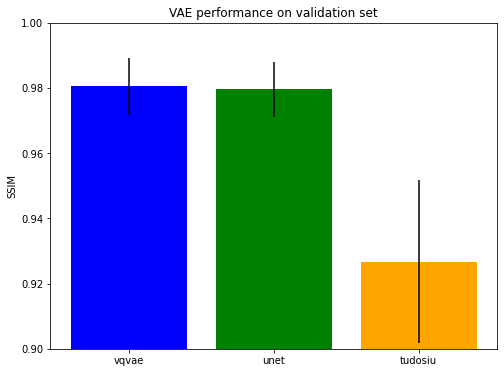

In [7]:
with open('ssims.p', 'rb') as f:
    datadict = pickle.load(f)

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize = (8,6))
ax.bar([0,1,2], datadict['means'], 
       yerr = datadict['std'], 
       color = ['blue', 'green', 'orange'], 
       tick_label = ['vqvae', 'unet', 'tudosiu'])

ax.set_ylabel('SSIM')
ax.set_ylim([0.9,1.0])
ax.set_title('VAE performance on validation set')
plt.show()